# __ID/X Partners x Rakamin Academy Virtual Intern__ <br>
### Final Project Assignment : <b>End-to-End Solution for Credit Loan</b> 

*by Aditya Bagus Pratama*

## __Business Understanding__

__Problem__ <br>
We are a company engaged in P2P Lending. We provide loans, and will benefit from the interest generated by the loans lent for a certain period of time. If we give a loan, but the borrower defaults, then we will experience a loss. We must know whether the credit to be given is safe/risk of default, so that we can avoid these losses.
<br>

__Business Metrics__ <br>
Net Profit Margin, Return of Assets, Minimum Loss
<br>

__Goal__ <br>
Identifying if a loan potentially bad/risk so that we can avoid or reject it, to minimize loss and maximize net profit margin.

__Objectives__ <br>
We will create a machine learning model that can identify if a loan is potentially bad / risky loan. If our model is reliable, our investment in risky loans will decrease, our our return of assets will increase and our net profit margin should also increase.

## __Data Requirement__


*   [LendingClub Credit Loan Dataset for 2007-2014](https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv)
*   [LendingClub Data Dictionary](https://docs.google.com/spreadsheets/d/1iT1JNOBwU4l616_rnJpo0iny7blZvNBs/edit?usp=sharing&ouid=106453318899954059421&rtpof=true&sd=true)

## __Data Collection__

#### Import All Libraries and Dependencies

In [ ]:
pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import itertools
import joblib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set();
import gspread as gs

from dython.nominal import associations
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression




#### Import Dataset

In [ ]:
# Loan Dataset
!wget --no-check-certificate \
  https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv \
  -O /tmp/loan_data_2007_2014.csv

loan = pd.read_csv('/tmp/loan_data_2007_2014.csv', low_memory=False)

--2022-08-27 08:34:03--  https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv
Resolving rakamin-lms.s3.ap-southeast-1.amazonaws.com (rakamin-lms.s3.ap-southeast-1.amazonaws.com)... 52.219.132.151
Connecting to rakamin-lms.s3.ap-southeast-1.amazonaws.com (rakamin-lms.s3.ap-southeast-1.amazonaws.com)|52.219.132.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240079969 (229M) [text/csv]
Saving to: ‘/tmp/loan_data_2007_2014.csv’

/tmp/loan_data_2007 100%[===================>] 228.96M  14.5MB/s    in 17s     

2022-08-27 08:34:22 (13.2 MB/s) - ‘/tmp/loan_data_2007_2014.csv’ saved [240079969/240079969]



In [ ]:
# Loan Dictionary
sheet_id = "1iT1JNOBwU4l616_rnJpo0iny7blZvNBs"
sheet_name = "LoanStats"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

loan_dict = pd.read_csv(url)
loan_dict.rename(columns = {'Unnamed: 0':'Features', 'Description':'Desc(EN)', 'Unnamed: 2':'Desc(IDN)'}, inplace = True)
loan_dict[['Features', 'Desc(EN)']]

,Features,Desc(EN)
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
...,...,...
74,inq_last_12m,Number of credit inquiries in past 12 months
75,acc_now_delinq,The number of accounts on which the borrower i...
76,tot_coll_amt,Total collection amounts ever owed
77,tot_cur_bal,Total current balance of all accounts


## __Data Understanding & Preparation__ 

#### Get Dataset Size

In [ ]:
loan.shape

(466285, 75)

#### Get Dataset Information

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [ ]:
loan.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By the information we get from the dataset, there're many null values, missing data, and a column named 'Unnamed : 0' which is nothing but copy of data index, so **we need to drop them.**



#### Identifying Missing Values

In [ ]:
miss_val = loan.isnull().mean()
miss_val[miss_val==1].index

Index(['annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m'],
      dtype='object')

#### Drop 'Unnamed : 0' and Missing-Values Columns

In [ ]:
drop_cols = ['Unnamed: 0', 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m']

data = loan.drop(columns=drop_cols, axis=1)

#### Get 'loan_status' insight
'loan_status' is our dependent column (target data), so we need to get insight from it

In [ ]:
title_font = dict(size=20, weight="bold")

def plot_count(data, y, title, **sns_kwargs):
    value_counts = data[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)

    loan_stats = data.groupby(y).agg({'id':'count'}).reset_index()
    loan_stats.columns = [y,'total']
    loan_stats['%'] = round(loan_stats['total']*100/sum(loan_stats['total']),2)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=data, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(loan_stats)


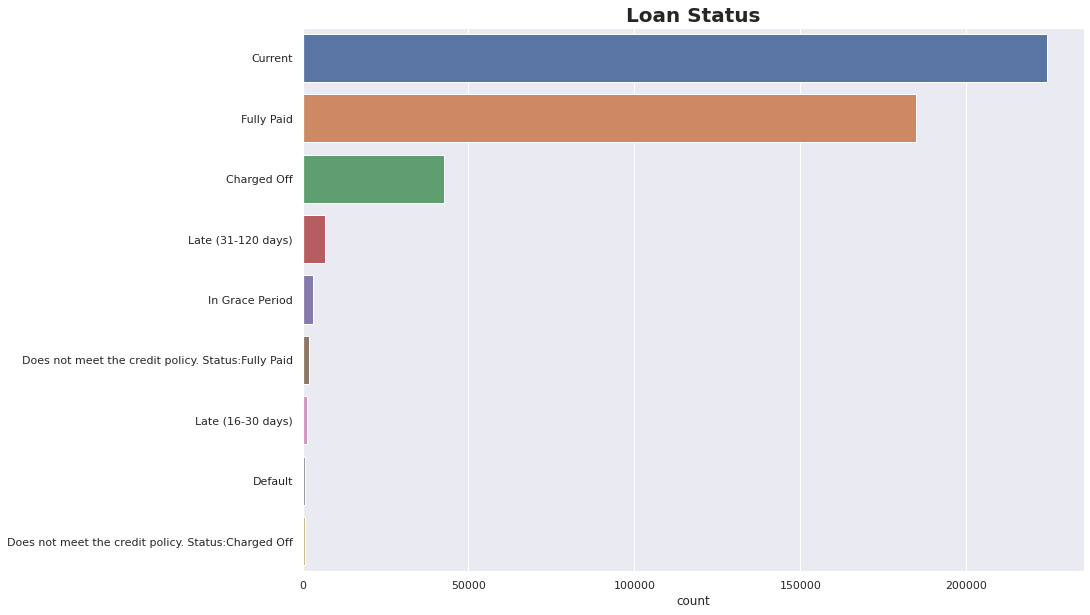

                                         loan_status   total      %
0                                        Charged Off   42475   9.11
1                                            Current  224226  48.09
2                                            Default     832   0.18
3  Does not meet the credit policy. Status:Charge...     761   0.16
4  Does not meet the credit policy. Status:Fully ...    1988   0.43
5                                         Fully Paid  184739  39.62
6                                    In Grace Period    3146   0.67
7                                  Late (16-30 days)    1218   0.26
8                                 Late (31-120 days)    6900   1.48


In [ ]:
plot_count(data, title="Loan Status",  y="loan_status")

In [ ]:
data.loan_status.value_counts().index

Index(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Does not meet the credit policy. Status:Fully Paid',
       'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype='object')

#### Categorizing 'loan_status'

As we can see from 'loan_status' values, there are values like "Current", "In Grace Period". The final status of those kind of loans can either be charged off or fully paid, which is **'ambigous'**, so we can't use those status. Another type, 'Late' , is kinda ambiguous too, but we had better not to invest in loan which is late, so we need to classify them as **'bad'** loan.

So, We'll categorized the loan 'final_status' as follows:
- Ambigous = ["Current", "In Grace Period"]
- Good Loans(Non-Risky) = ["Fully Paid", "Does not meet the credit policy. Status:Fully Paid"]
- Bad Loans(Risky) = ["Charged Off", "Late (31-120 days)", "Late (16-30 days)", "Default", "Does not meet the credit policy. Status:Charged Off"]

In [ ]:
ambigous = ['Current', 'In Grace Period']
good_loan = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
bad_loan = ["Charged Off", "Late (31-120 days)", "Late (16-30 days)", "Default", "Does not meet the credit policy. Status:Charged Off"]

#### Making new column, called 'final_status', containing categorized 'loan_status'

In [ ]:
# data['final_status'] = np.where(data['loan_status'].isin(good_loan), 'good'(np.where(data['loan_status'].isin(ambigous), 'ambigous')), 'risky')
data['final_status'] = np.where(data['loan_status'].isin(good_loan), 'good',
                                np.where(data['loan_status'].isin(ambigous), 'ambigous',
                                         'bad'))

#### Get data percentage by 'final_status'

In [ ]:
cat_data = data.groupby('final_status').agg({'id':'count'}).reset_index()
cat_data.columns = ['final_status','total']
cat_data['%'] = round(cat_data['total']*100/sum(cat_data['total']),3)
cat_data

,final_status,total,%
0,ambigous,227372,48.762
1,bad,52186,11.192
2,good,186727,40.046


#### Plotting Loan Status Categories

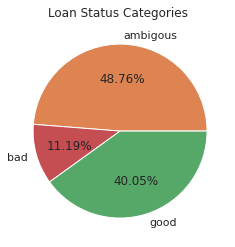

In [ ]:
plt.title('Loan Status Categories ')
colours = {'ambigous': 'C1',
           'bad': 'C3',
           'good': 'C2'
           }
plt.pie(cat_data['total'], colors=[colours[key] for key in cat_data['final_status']], labels=cat_data['final_status'], autopct='%.2f%%')
plt.show()

#### Get Rid Of Ambigous Values

As we have decided before, that we won't use ambigous data, so we need to drop them

In [ ]:
data = data[data.loan_status.isin(ambigous) == False]
cat_data = data.groupby('final_status').agg({'id':'count'}).reset_index()
cat_data.columns = ['final_status','total']
cat_data['%'] = round(cat_data['total']*100/sum(cat_data['total']),3)
cat_data

,final_status,total,%
0,bad,52186,21.843
1,good,186727,78.157


#### Plotting Good Loan vs Bad Loan

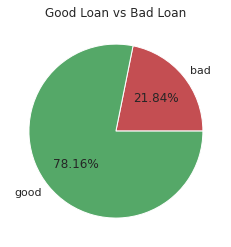

In [ ]:
plt.title('Good Loan vs Bad Loan')
colours = {'bad': 'C3',
           'good': 'C2'
           }
plt.pie(cat_data['total'], colors=[colours[key] for key in cat_data['final_status']], labels=cat_data['final_status'], autopct='%.2f%%')
plt.show()

#### Feature Engineering 'target'

we need a numerical version of final_status value, so a new feature called `target` is created to represent `final_status` in numerical ways

In [ ]:
# Feature Engineering Target
data['target'] = np.where((data['final_status'] =='good'),1,0)

In [ ]:
datfig = data.groupby('target').agg({'id':'count'}).reset_index()
datfig.columns = ['target','total']
datfig['%'] = round(datfig['total']*100/sum(datfig['total']),3)
datfig

,target,total,%
0,0,52186,21.843
1,1,186727,78.157


In [ ]:
# get info of newest data dimension after dropping null & missing values
data.shape

(238913, 59)

#### Variable Correlation

In [ ]:
inter_df = data.copy()

In [ ]:
inter_df.shape

(238913, 59)

In [ ]:
correlations = (inter_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=0)
                         .dropna(how="all", axis=1)
)

In [ ]:
correlations["target"].abs().sort_values(ascending=False)

target                         1.000000
total_rec_prncp                0.470166
recoveries                     0.413134
last_pymnt_amnt                0.401381
total_pymnt                    0.358006
total_pymnt_inv                0.354663
out_prncp                      0.304491
out_prncp_inv                  0.304478
collection_recovery_fee        0.278468
int_rate                       0.255543
total_rec_late_fee             0.163716
dti                            0.128055
revol_util                     0.098403
member_id                      0.097254
id                             0.096007
tot_cur_bal                    0.076424
funded_amnt                    0.074942
loan_amnt                      0.074628
funded_amnt_inv                0.072800
total_rec_int                  0.072541
annual_inc                     0.060564
total_rev_hi_lim               0.055897
installment                    0.055635
inq_last_6mths                 0.055262
delinq_2yrs                    0.030770


In [ ]:
# Filtering vmin-vmax correlation
vmin, vmax = 0.1, 0.99

unstack_corr = correlations.unstack()
# positive correlation
pos_corr = (unstack_corr > vmin) & (unstack_corr < vmax)
# negative correlation
neg_corr = (unstack_corr > -vmax) & (unstack_corr < -vmin)
# high correlation
high_corr = unstack_corr[pos_corr | neg_corr]

trim_corr = high_corr.sort_values(ascending=False).unstack()

In [ ]:
# Create a mask to form the lower triangular matrix
mask = np.zeros_like(trim_corr)
mask[np.triu_indices_from(mask)] = True

In [ ]:
# analyzing the high correlation from features/columns 
aff_loan = high_corr.loc["target"].abs().sort_values(ascending=False)
aff_loan

total_rec_prncp            0.470166
recoveries                 0.413134
last_pymnt_amnt            0.401381
total_pymnt                0.358006
total_pymnt_inv            0.354663
out_prncp                  0.304491
out_prncp_inv              0.304478
collection_recovery_fee    0.278468
int_rate                   0.255543
total_rec_late_fee         0.163716
dti                        0.128055
dtype: float64

In [ ]:
# marking high correlation with threshold 0.9
th = 0.9

# affected collision
aff_coll = (high_corr.abs()
                             .loc[high_corr > th]
                             .loc[aff_loan.index, aff_loan.index]
                             .sort_values(ascending=False)
)
aff_coll

total_rec_prncp  total_pymnt        0.973498
total_pymnt      total_rec_prncp    0.973498
total_rec_prncp  total_pymnt_inv    0.967971
total_pymnt_inv  total_rec_prncp    0.967971
dtype: float64

In [ ]:
left_index = aff_coll.index.get_level_values(0)
right_index = aff_coll.index.get_level_values(1)

def remove_collide_index(left_index, right_index):
    include, exclude = [], []

    for left, right in zip(left_index, right_index):
        if left not in include and left not in exclude:
            include.append(left)
        if right not in include and right not in exclude:
            exclude.append(right)
        
    return include, exclude


include_aff_col, exclude_affect_col = remove_collide_index(left_index, right_index)
include_aff_col, exclude_affect_col

(['total_rec_prncp'], ['total_pymnt', 'total_pymnt_inv'])

In [ ]:
aff_num_cols = aff_loan[~aff_loan.index.isin(exclude_affect_col)].index.to_list()
aff_num_cols

['total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'out_prncp',
 'out_prncp_inv',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'dti']

### **Exploratory Data Analysis**

#### Generating common insight

In [ ]:
# making some functions for EDA

def plot_dist(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

#### Distribution of Loan Status and Total Principal Loan that has been paid

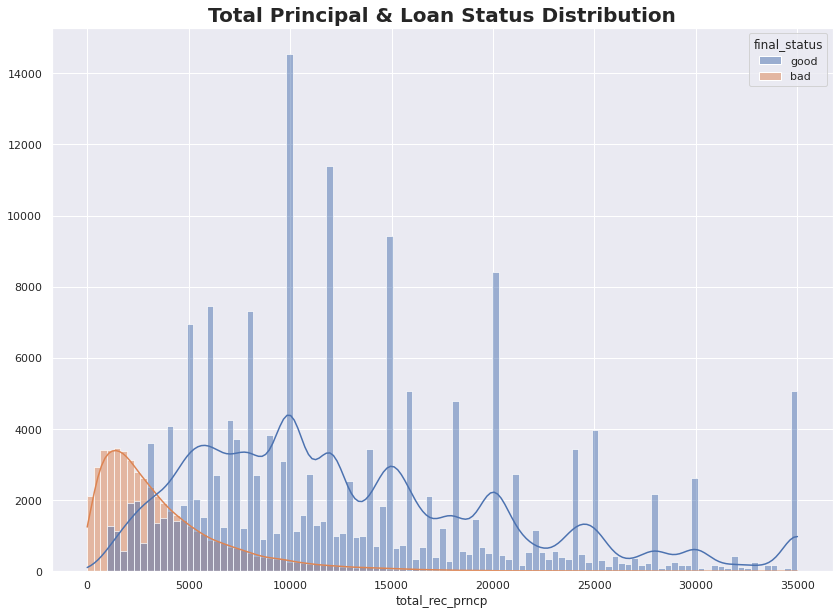

In [ ]:
plot_dist(df=inter_df, x="total_rec_prncp", hue="final_status", title="Total Principal & Loan Status Distribution")

Principal is the amount of the principal loan lent to the borrower. In other words, it's the original amount of money lent. Most people who experience default have not been able to pay the principal payment until maturity, it can be seen from the distribution of payments above.

#### Distribution of Loan Status and Loan Amount Distribution

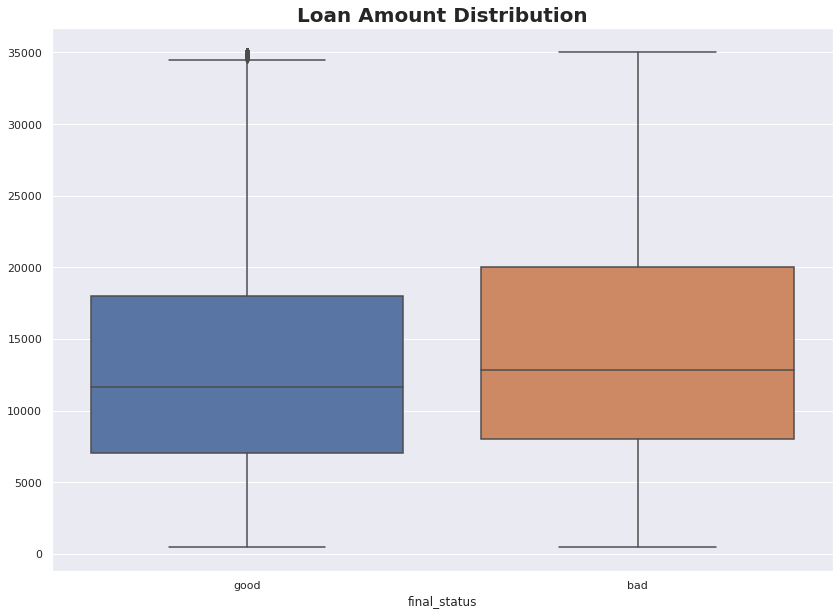

,count,mean,std,min,25%,50%,75%,max
final_status,,,,,,,,
bad,52186.0,14624.953053,8390.633508,500.0,8000.0,12800.0,20000.0,35000.0
good,186727.0,13167.962855,7944.742527,500.0,7000.0,11625.0,18000.0,35000.0


In [ ]:
x, y = "final_status", "loan_amnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Loan Amount Distribution")
inter_df.groupby(x)[y].describe()

The average loan amount is in the `bad` status.

#### Distribution of Loan Status and Total Payment Accepted

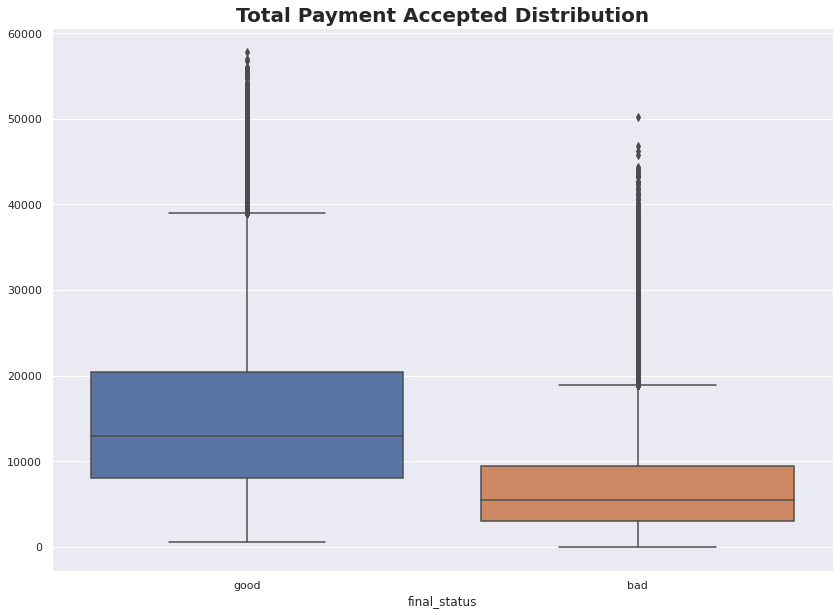

,count,mean,std,min,25%,50%,75%,max
final_status,,,,,,,,
bad,52186.0,7024.191781,5675.182531,0.00,3012.5975,5491.77000,9372.74250,50197.03000
good,186727.0,15160.113585,9452.545563,503.54,8035.1450,12930.93777,20429.38559,57777.57987


In [ ]:
x, y = "final_status", "total_pymnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Total Payment Accepted Distribution")
inter_df.groupby(x)[y].describe()


It's clear that the highest total payments are on loans with `good` status.

#### Borrower's States Origin

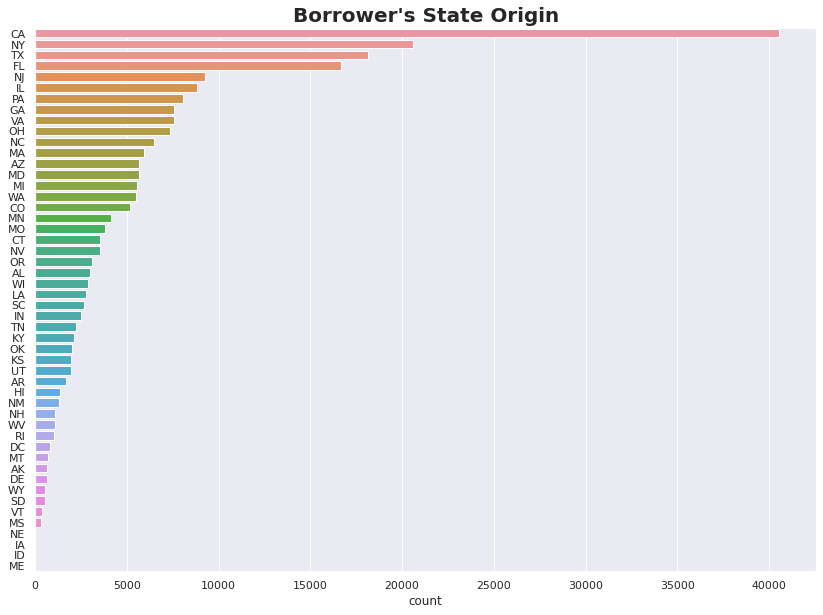

   addr_state  total      %
0          AK    633   0.26
1          AL   2973   1.24
2          AR   1670   0.70
3          AZ   5686   2.38
4          CA  40550  16.97
5          CO   5184   2.17
6          CT   3554   1.49
7          DC    794   0.33
8          DE    628   0.26
9          FL  16647   6.97
10         GA   7574   3.17
11         HI   1373   0.57
12         IA     13   0.01
13         ID      9   0.00
14         IL   8806   3.69
15         IN   2524   1.06
16         KS   1960   0.82
17         KY   2140   0.90
18         LA   2783   1.16
19         MA   5912   2.47
20         MD   5680   2.38
21         ME      4   0.00
22         MI   5571   2.33
23         MN   4122   1.73
24         MO   3795   1.59
25         MS    325   0.14
26         MT    713   0.30
27         NC   6459   2.70
28         NE     14   0.01
29         NH   1094   0.46
30         NJ   9243   3.87
31         NM   1288   0.54
32         NV   3553   1.49
33         NY  20608   8.63
34         OH   7333

In [ ]:
plot_count(inter_df, y="addr_state", title="Borrower's State Origin")

#### Separating numeric features with categorical

In [ ]:
nums = [] #numerical
cats = [] #categorical
for i in inter_df.columns:
  if inter_df[i].dtype == 'object':
    cats.append(i)
  else:
    nums.append(i)
print('numerical count = ',len(nums))
print('nums = ',nums)
print('categorical count = ',len(cats))
print('cats = ',cats)

numerical count =  36
nums =  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']
categorical count =  23
cats =  ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'final_status']


#### Summary for Categorical Features

In [ ]:
inter_df[cats].describe().transpose()

,count,unique,top,freq
term,238913,2,36 months,186469
grade,238913,7,B,72239
sub_grade,238913,35,B3,17375
emp_title,225435,129889,Teacher,1652
emp_length,229688,11,10+ years,71312
home_ownership,238913,6,MORTGAGE,117376
verification_status,238913,3,Verified,88823
issue_d,238913,91,Oct-14,9884
loan_status,238913,7,Fully Paid,184739
pymnt_plan,238913,2,n,238906


* Features `emp_title`,`url`,`desc`,`title`,`zip_code`,`addr_state` will not be used since there are too many unique values
* Feature `application_type` will also not be used since it only has 1 unique value, so no information can be obtained from the feature.

In [ ]:
#data dimension before dropping
print('data dimension before dropping = ',inter_df.shape)

#dropping
inter_df.drop(columns=['emp_title','url','desc','title','zip_code','addr_state','application_type'],inplace=True)

#data dimension after dropping
print('data dimension after dropping = ',inter_df.shape)

data dimension before dropping =  (238913, 59)
data dimension after dropping =  (238913, 52)


#### Summary for Numerical Features

In [ ]:
inter_df[nums].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,238913.0,8.584147e+06,9.288258e+06,54734.00,1.382529e+06,5.524581e+06,12485970.00,3.785416e+07
member_id,238913.0,9.703611e+06,1.007888e+07,70473.00,1.616779e+06,6.479428e+06,14457393.00,4.061688e+07
loan_amnt,238913.0,1.348621e+04,8.066725e+03,500.00,7.200000e+03,1.200000e+04,18000.00,3.500000e+04
funded_amnt,238913.0,1.344080e+04,8.042190e+03,500.00,7.200000e+03,1.200000e+04,18000.00,3.500000e+04
funded_amnt_inv,238913.0,1.331266e+04,8.080099e+03,0.00,7.125000e+03,1.191431e+04,18000.00,3.500000e+04
int_rate,238913.0,1.385545e+01,4.380770e+00,5.42,1.099000e+01,1.367000e+01,16.59,2.606000e+01
installment,238913.0,4.169350e+02,2.437504e+02,15.67,2.394100e+02,3.652300e+02,545.96,1.408130e+03
annual_inc,238909.0,7.192866e+04,5.510420e+04,1896.00,4.500000e+04,6.145000e+04,86000.00,7.141778e+06
dti,238913.0,1.643968e+01,7.698582e+00,0.00,1.072000e+01,1.614000e+01,21.88,3.999000e+01
delinq_2yrs,238884.0,2.483004e-01,7.358723e-01,0.00,0.000000e+00,0.000000e+00,0.00,2.900000e+01


**Info:**
* `id` : the unique LC assigned ID for the loan list
* `member_id` : a unique ID assigned by LC to borrower members
* `loan_amnt` : the amount requested by borrower
* `funded_amnt` : the amount given to the borrower
* `funded_amnt_inv` : the amount that investors give to borrowers
* `int_rate` : loan interest

* `annual_inc` : the borrower's annual income
* `dti` : the ratio between loan and income
* `delinq_2yrs` : the number of incidents of 30 days arrears in the borrower's credit file for the last 2 years
* `inq_last_6mnths` : the number of inquiries for the last 6 months (except cars and mortgages)
* `mths_since_last_delinq` : the number of months since the borrower's last arrears.
* `mths_since_last_record` : Number of months since last public record

* `pub_rec` : the number of public records due
* `revol_bal` : the total revolving credit balance (the portion of credit card spend that was not paid at the end of the billing cycle)
* `revol_util` : the revolving path utilization rate, or the number of credits the borrower uses relative to all available revolving credits.
* `total_acc` : the total number of current lines of credit in the borrower's credit file
* `out_prncp` : Remaining loan principal for the total amount funded
* `out_prncp_inv` : the remaining principal of the loan for a portion of the total amount funded by investors

* `total_pymnt_inv` : the Payment received to date for a portion of the total amount funded by investors
* `total_rec_prncp` : the principal payment received to date
* `total_rec_int` : the interest received to date
* `total_rec_late_fee` : late fee received to date
* `recoveries` : post charge off dirty recovery
* `collection_recovery_fee` : post charge off collection fee

* `collections_12_mths_ex_med` : the number of collections in the last 12 months excluding medical
* `mths_since_last_major_derog` : the month since ranking last 90 days or worse
* `policy_code` : policy_code=1 (publicly available new product); policy_code=2 (not publicly available)
* `acc_now_delinq` : the number of accounts in which the borrower is now in arrears
* `tot_coll_amt` : the total amount of collection ever owed
* `tot_cul_bar` : Total current balance of all accounts
* `total_rev_hi_lim` : a revolving/revolving Total credit/high credit limit

#### Data with Small Unique Value

In [ ]:
# Filtering data with less than 10 unique values
inter_df.nunique()[inter_df.nunique() < 10].sort_values()

policy_code                   1
term                          2
pymnt_plan                    2
initial_list_status           2
final_status                  2
target                        2
verification_status           3
home_ownership                6
acc_now_delinq                6
grade                         7
loan_status                   7
collections_12_mths_ex_med    7
dtype: int64

Based on filter result above, we need to drop **policy_code** as it has only 1 value.

In [ ]:
#check data dimension before
print('data dimension before dropping = ',inter_df.shape)

inter_df.drop(['policy_code'], inplace=True, axis = 1)

#check data dimension after
print('data dimension after dropping = ',inter_df.shape)

data dimension before dropping =  (238913, 52)
data dimension after dropping =  (238913, 51)


#### Separating Numeric Features with Categorical

In [ ]:
nums1 = [] #numerical
cats1 = [] #categorical
for i in inter_df.columns:
  if inter_df[i].dtype == 'object':
    cats1.append(i)
  else:
    nums1.append(i)
print('numerical count = ',len(nums1))
print('nums = ',nums1)
print('categorical count = ',len(cats1))
print('cats = ',cats1)

numerical count =  35
nums =  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']
categorical count =  16
cats =  ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'final_status']


#### Categorical Features Summary

In [ ]:
#remove spaces
inter_df.term=inter_df.term.str.lstrip()

In [ ]:
inter_df[cats1].describe().transpose()

,count,unique,top,freq
term,238913,2,36 months,186469
grade,238913,7,B,72239
sub_grade,238913,35,B3,17375
emp_length,229688,11,10+ years,71312
home_ownership,238913,6,MORTGAGE,117376
verification_status,238913,3,Verified,88823
issue_d,238913,91,Oct-14,9884
loan_status,238913,7,Fully Paid,184739
pymnt_plan,238913,2,n,238906
purpose,238913,14,debt_consolidation,139085


In [ ]:
for i in cats1:
  print('-----'*10)
  print(i)
  print(inter_df[i].value_counts())

--------------------------------------------------
term
36 months    186469
60 months     52444
Name: term, dtype: int64
--------------------------------------------------
grade
B    72239
C    61042
A    39500
D    38715
E    18086
F     7348
G     1983
Name: grade, dtype: int64
--------------------------------------------------
sub_grade
B3    17375
B4    16126
C1    14012
B2    13927
B5    13414
C2    13377
C3    11923
B1    11397
C4    11232
A5    11101
C5    10498
A4    10380
D1     9529
D2     8713
D3     7613
D4     7048
A3     6753
D5     5812
A2     5765
A1     5501
E1     4370
E2     4344
E3     3541
E4     3151
E5     2680
F1     2107
F2     1684
F3     1509
F4     1143
F5      905
G1      670
G2      481
G3      332
G4      259
G5      241
Name: sub_grade, dtype: int64
--------------------------------------------------
emp_length
10+ years    71312
2 years      22352
< 1 year     19998
3 years      19395
5 years      17297
1 year       16078
4 years      15402
6 years      

* For features `issue_d`,`earliest_cr_line`, `last_pymnt_d`, `next_pymnt_d`, and `last_credit_pull_d`, the datatype can be changed into `datetime`
* The label on feature `initial_list_status` can be changed into `binary`
* The 'ANY' and 'NONE' labels on the `home_ownership` feature can be combined with the 'OTHER' label
* Since feature `target` is a feature engineering of `final_status`, and `final_status` itself is a feature engineering of `loan_status`, so that `final_status` and `loan_status` can be dropped

#### Numerical Features Summary

In [ ]:
inter_df[nums1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,238913.0,8.584147e+06,9.288258e+06,54734.00,1.382529e+06,5.524581e+06,12485970.00,3.785416e+07
member_id,238913.0,9.703611e+06,1.007888e+07,70473.00,1.616779e+06,6.479428e+06,14457393.00,4.061688e+07
loan_amnt,238913.0,1.348621e+04,8.066725e+03,500.00,7.200000e+03,1.200000e+04,18000.00,3.500000e+04
funded_amnt,238913.0,1.344080e+04,8.042190e+03,500.00,7.200000e+03,1.200000e+04,18000.00,3.500000e+04
funded_amnt_inv,238913.0,1.331266e+04,8.080099e+03,0.00,7.125000e+03,1.191431e+04,18000.00,3.500000e+04
int_rate,238913.0,1.385545e+01,4.380770e+00,5.42,1.099000e+01,1.367000e+01,16.59,2.606000e+01
installment,238913.0,4.169350e+02,2.437504e+02,15.67,2.394100e+02,3.652300e+02,545.96,1.408130e+03
annual_inc,238909.0,7.192866e+04,5.510420e+04,1896.00,4.500000e+04,6.145000e+04,86000.00,7.141778e+06
dti,238913.0,1.643968e+01,7.698582e+00,0.00,1.072000e+01,1.614000e+01,21.88,3.999000e+01
delinq_2yrs,238884.0,2.483004e-01,7.358723e-01,0.00,0.000000e+00,0.000000e+00,0.00,2.900000e+01


#### Univariate Analysis : Categorical Features

In [ ]:
to_date = []
cats2 = []
for i in cats1:
  if inter_df[i].nunique() > 35:
    to_date.append(i)
  else:
    cats2.append(i)
cats1 = cats2.copy()

In [ ]:
print(cats1)
print(to_date)

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'final_status']
['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


In [ ]:
# Ordering feature `emp_length`
length = ['< 1 year','1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
inter_df['emp_length'] = pd.Categorical(inter_df['emp_length'], categories=length, ordered=True)

In [ ]:
# Ordering feature `sub_grade`
temp = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5']
inter_df['sub_grade'] = pd.Categorical(inter_df['sub_grade'], categories=temp, ordered=True)

#### Feature `term`

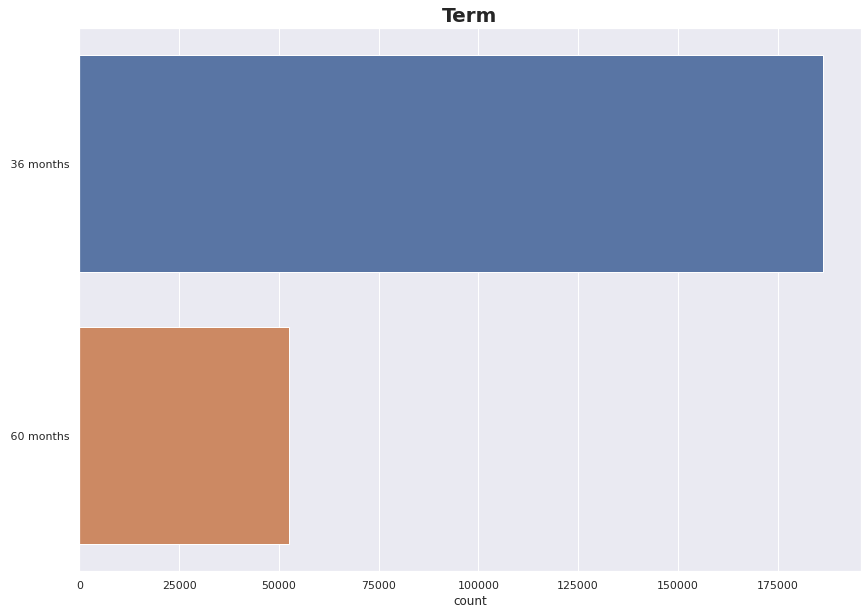

         term   total      %
0   36 months  186469  78.05
1   60 months   52444  21.95


In [ ]:
y = "term"
order = inter_df[y].sort_values().unique()
plot_count(data, y=y, title="Term")

The `term` feature is dominated by the label '36 months' with a percentage of 78.05% of the total population.

#### Feature `grade`

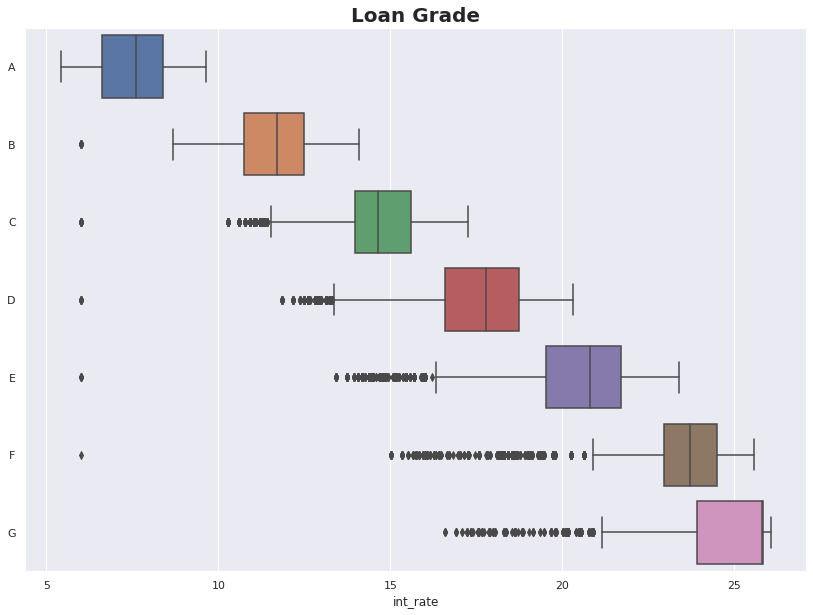

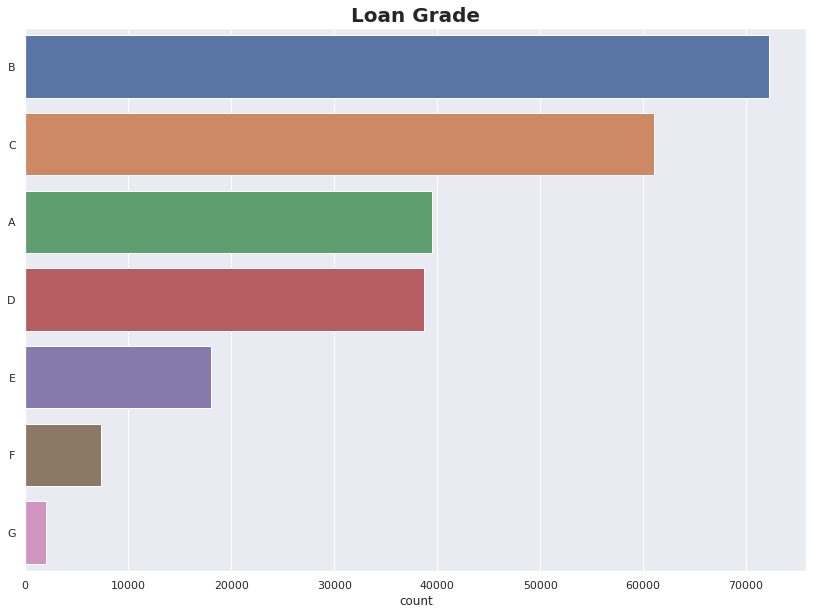

  grade  total      %
0     A  39500  16.53
1     B  72239  30.24
2     C  61042  25.55
3     D  38715  16.20
4     E  18086   7.57
5     F   7348   3.08
6     G   1983   0.83


,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,39500.0,7.548551,1.002864,5.42,6.62,7.62,8.39,9.63
B,72239.0,11.654911,1.280894,6.00,10.74,11.71,12.49,14.09
C,61042.0,14.760351,1.229674,6.00,13.98,14.64,15.61,17.27
D,38715.0,17.623237,1.474671,6.00,16.59,17.77,18.75,20.31
E,18086.0,20.362172,1.887752,6.00,19.52,20.80,21.70,23.40
F,7348.0,23.192361,2.053790,6.00,22.95,23.70,24.50,25.57
G,1983.0,24.290570,2.460741,16.59,23.91,25.80,25.83,26.06


In [ ]:
x, y = "int_rate", "grade"
order = inter_df[y].sort_values().unique()
plot_boxplot(inter_df, x=x, y=y, title="Loan Grade", order=order)
plot_count(inter_df, y=y, title="Loan Grade")
inter_df.groupby(y)[x].describe()

Loans are graded from the letters of the alphabet A to G, the closer to G the higher the interest rate paid. Feature `grade` is dominated by labels B with 30.24% of Total Population

#### Feature `sub_grade`

In [ ]:
sub_grade = inter_df.groupby('sub_grade').agg({'id':'count'}).reset_index()
sub_grade.columns=['sub_grade','total']
sub_grade['%'] = round(sub_grade.total*100/sum(sub_grade.total),3)
sub_grade

,sub_grade,total,%
0,A1,5501,2.303
1,A2,5765,2.413
2,A3,6753,2.827
3,A4,10380,4.345
4,A5,11101,4.646
5,B1,11397,4.770
6,B2,13927,5.829
7,B3,17375,7.273
8,B4,16126,6.750
9,B5,13414,5.615


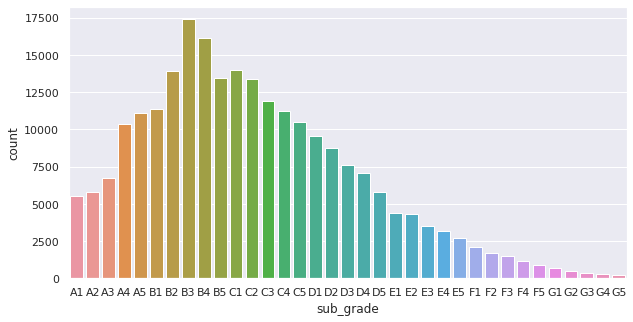

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=inter_df['sub_grade'])
plt.show()

The `sub_grade` feature is dominated by the labels 'B3' with a percentage 7.273%, respectively, of the total population.

#### Feature `emp_length`

In [ ]:
emp_length = inter_df.groupby('emp_length').agg({'id':'count'}).reset_index()
emp_length.columns=['emp_length','total']
emp_length['%'] = round(emp_length.total*100/sum(emp_length.total),3)
emp_length

,emp_length,total,%
0,< 1 year,19998,8.707
1,1 year,16078,7.000
2,2 years,22352,9.731
3,3 years,19395,8.444
4,4 years,15402,6.706
5,5 years,17297,7.531
6,6 years,14300,6.226
7,7 years,13466,5.863
8,8 years,11092,4.829
9,9 years,8996,3.917


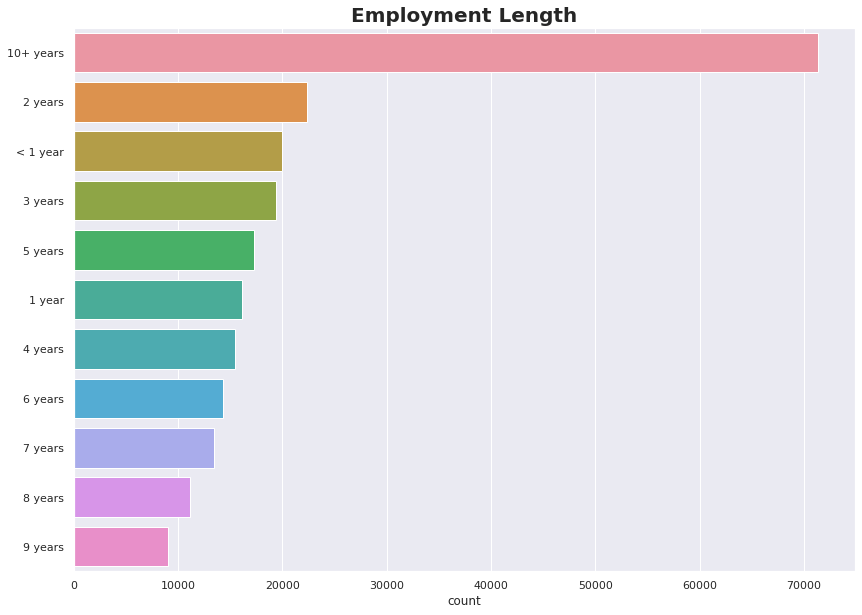

   emp_length  total      %
0      1 year  16078   7.00
1   10+ years  71312  31.05
2     2 years  22352   9.73
3     3 years  19395   8.44
4     4 years  15402   6.71
5     5 years  17297   7.53
6     6 years  14300   6.23
7     7 years  13466   5.86
8     8 years  11092   4.83
9     9 years   8996   3.92
10   < 1 year  19998   8.71


In [ ]:
y = "emp_length"
order = inter_df[y].sort_values().unique()
plot_count(data, y=y, title="Employment Length")

The `emp_length` feature is dominated by the label '10+ years' with a percentage of 31.05% of the total population

#### Home Ownership Status

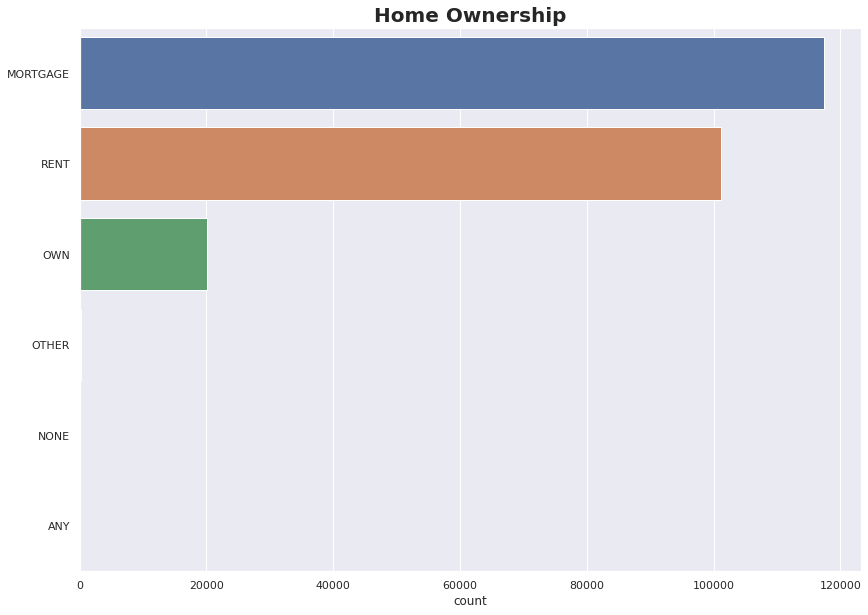

  home_ownership   total      %
0            ANY       1   0.00
1       MORTGAGE  117376  49.13
2           NONE      48   0.02
3          OTHER     179   0.07
4            OWN   20123   8.42
5           RENT  101186  42.35


In [ ]:
y = "home_ownership"
order = inter_df[y].sort_values().unique()
plot_count(inter_df, y=y, title="Home Ownership")

The home_ownership feature is dominated by the MORTGAGE label with a percentage of 49.13% of the total population. NONE and ANY labels can be combined with OTHER label labels. Most of the borrowers delegate their house as collateral for the loan, while only a few of the borrowers own their own house.

#### Feature `pymnt_plan`

In [ ]:
pymnt_plan = inter_df.groupby('pymnt_plan').agg({'id':'count'}).reset_index()
pymnt_plan.columns=['pymnt_plan','total']
pymnt_plan['%'] = round(pymnt_plan.total*100/sum(pymnt_plan.total),3)
pymnt_plan=pymnt_plan.sort_values('%',ascending=False)
pymnt_plan

,pymnt_plan,total,%
0,n,238906,99.997
1,y,7,0.003


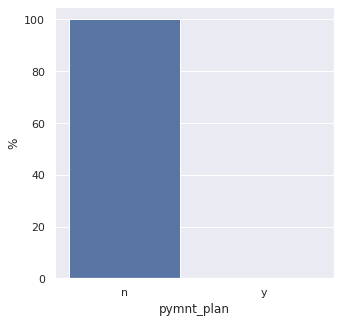

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(x=pymnt_plan['pymnt_plan'],y=pymnt_plan['%'])
plt.show()

The `pymnt_plan` feature is dominated by label n with a percentage of 99.997% of the total population. **Extremely Imbalance**

#### Feature `purpose`

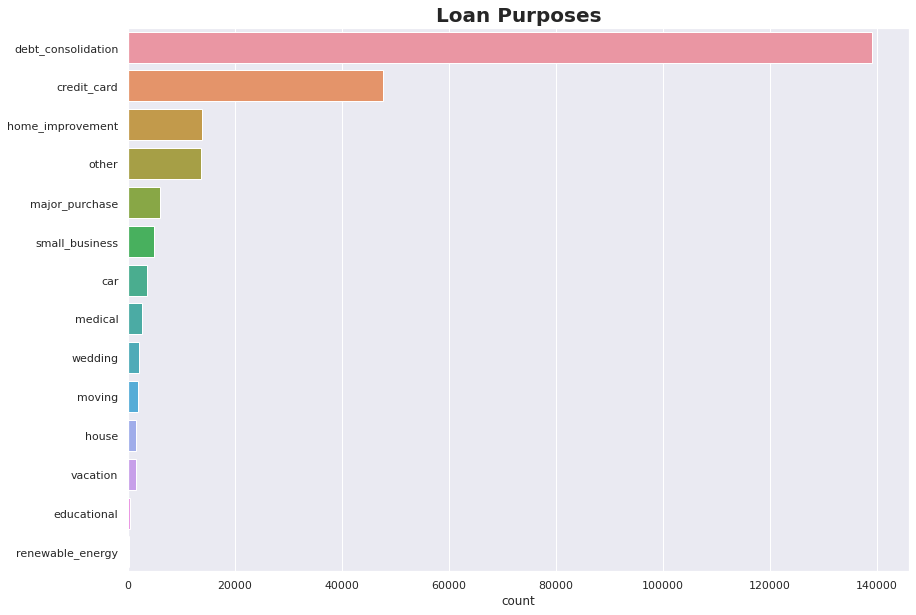

               purpose   total      %
0                  car    3505   1.47
1          credit_card   47640  19.94
2   debt_consolidation  139085  58.22
3          educational     422   0.18
4     home_improvement   13891   5.81
5                house    1537   0.64
6       major_purchase    5974   2.50
7              medical    2714   1.14
8               moving    1900   0.80
9                other   13705   5.74
10    renewable_energy     256   0.11
11      small_business    4799   2.01
12            vacation    1468   0.61
13             wedding    2017   0.84


In [ ]:
plot_count(inter_df, y="purpose", title="Loan Purposes")

The `purpose` feature is dominated by the debt consolidation label with a percentage of 58.22% of the total population

#### Feature `initial_list_status`

In [ ]:
initial_list_status = inter_df.groupby('initial_list_status').agg({'id':'count'}).reset_index()
initial_list_status.columns=['initial_list_status','total']
initial_list_status['%'] = round(initial_list_status.total*100/sum(initial_list_status.total),3)
initial_list_status=initial_list_status.sort_values('%',ascending=False)
initial_list_status

,initial_list_status,total,%
0,f,177714,74.384
1,w,61199,25.616


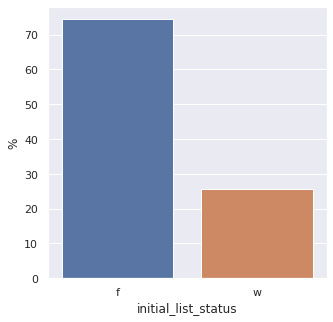

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(x=initial_list_status['initial_list_status'],y=initial_list_status['%'])
plt.show()

The `initial_list_status` feature is dominated by label f with a percentage of 74.384% of the total population

**Final Observation:**
* The `term` feature is dominated by `36 months` label
* Feature `grade` is dominated by labels `B`
* Feature `sub_grade` is dominated by sub of labels `B3`
* Feature `emp_length` is dominated by users who work `10 years and over`
* The `home_ownership` feature is dominated by the `MORTGAGE` label. `NONE` and `ANY` labels can be combined with `OTHER` label labels
* Feature `verification_status` with the highest count is `verified` label
* Feature `pymnt_plan` is dominated by label `n` (extremely imbalance)
* The `purpose` feature is dominated by the `debt_consolidation` label
* The `initial_list_status` feature is dominated by `f` labels

#### Feature Engineering : Date

In [ ]:
print(to_date)

['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']


Separating `month` and `year`

In [ ]:
inter_df['issue_d_month'] = inter_df.issue_d.str[:3]
inter_df['issue_d_year'] = np.where(inter_df.issue_d.str[4:].astype('float64')>30,'19'+ inter_df.issue_d.str[4:],'20'+ inter_df.issue_d.str[4:])

inter_df['earliest_cr_line_month'] = inter_df.earliest_cr_line.str[:3]
inter_df['earliest_cr_line_year'] = np.where(inter_df.earliest_cr_line.str[4:].astype('float64')>30,'19'+ inter_df.earliest_cr_line.str[4:],'20'+ inter_df.earliest_cr_line.str[4:])

inter_df['last_pymnt_d_month'] = inter_df.last_pymnt_d.str[:3]
inter_df['last_pymnt_d_year'] = np.where(inter_df.last_pymnt_d.str[4:].astype('float64')>30,'19'+ inter_df.last_pymnt_d.str[4:],'20'+ inter_df.last_pymnt_d.str[4:])

inter_df['next_pymnt_d_month'] = inter_df.next_pymnt_d.str[:3]
inter_df['next_pymnt_d_year'] = np.where(inter_df.next_pymnt_d.str[4:].astype('float64')>30,'19'+ inter_df.next_pymnt_d.str[4:],'20'+ inter_df.next_pymnt_d.str[4:])

inter_df['last_credit_pull_d_month'] = inter_df.last_credit_pull_d.str[:3]
inter_df['last_credit_pull_d_year'] = np.where(inter_df.last_credit_pull_d.str[4:].astype('float64')>30,'19'+ inter_df.last_credit_pull_d.str[4:],'20'+ inter_df.last_credit_pull_d.str[4:])

In [ ]:
inter_df[['issue_d_month','issue_d_year', 'earliest_cr_line_month', 'earliest_cr_line_year',
     'last_pymnt_d_month', 'last_pymnt_d_year', 'next_pymnt_d_month','next_pymnt_d_year', 
     'last_credit_pull_d_month','last_credit_pull_d_year']].head()

,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,next_pymnt_d_month,next_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,Dec,2011,Jan,1985,Jan,2015,NaN,NaN,Jan,2016
1,Dec,2011,Apr,1999,Apr,2013,NaN,NaN,Sep,2013
2,Dec,2011,Nov,2001,Jun,2014,NaN,NaN,Jan,2016
3,Dec,2011,Feb,1996,Jan,2015,NaN,NaN,Jan,2015
5,Dec,2011,Nov,2004,Jan,2015,NaN,NaN,Sep,2015


In [ ]:
inter_df[['issue_d','issue_d_month','issue_d_year',
     'earliest_cr_line','earliest_cr_line_month','earliest_cr_line_year',
     'last_pymnt_d','last_pymnt_d_month','last_pymnt_d_year',
     'next_pymnt_d','next_pymnt_d_month','next_pymnt_d_year',
     ]].isnull().sum()

issue_d                        0
issue_d_month                  0
issue_d_year                   0
earliest_cr_line              29
earliest_cr_line_month        29
earliest_cr_line_year         29
last_pymnt_d                 376
last_pymnt_d_month           376
last_pymnt_d_year            376
next_pymnt_d              227214
next_pymnt_d_month        227214
next_pymnt_d_year         227214
dtype: int64

In [ ]:
# Ordering feature emy_length
temp = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
month = ['issue_d_month', 'earliest_cr_line_month','last_pymnt_d_month','next_pymnt_d_month','last_credit_pull_d_month']
for i in month:
  inter_df[i] = pd.Categorical(inter_df[i], categories=temp, ordered=True)

#### Feature `issue_d_year`

In [ ]:
 a = inter_df.groupby(['issue_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
 a['%'] = round(a['total']*100/sum(a['total']),3)
 a

,issue_d_year,total,%
0,2007,603,0.252
1,2008,2393,1.002
2,2009,5281,2.210
3,2010,12530,5.245
4,2011,19740,8.262
5,2012,49840,20.861
6,2013,73514,30.770
7,2014,75012,31.397


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


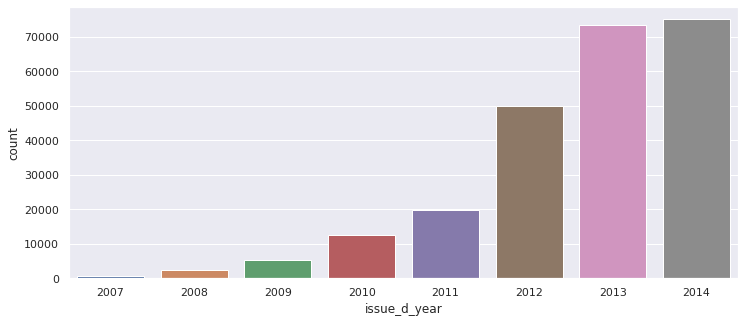

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(inter_df['issue_d_year'].sort_values())
plt.show()

In the feature `issue_d_year` 31.397% of the total population is dominated by the label '2014'.

#### Feature `earliest_cr_line_year`

In [ ]:
b = inter_df.groupby(['earliest_cr_line_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
b['%'] = round(b['total']*100/sum(b['total']),3)
b

,earliest_cr_line_year,total,%
0,1946,1,0.000
1,1948,1,0.000
2,1950,1,0.000
3,1954,4,0.002
4,1955,4,0.002
...,...,...,...
56,2007,6477,2.711
57,2008,3602,1.508
58,2009,1603,0.671
59,2010,970,0.406


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


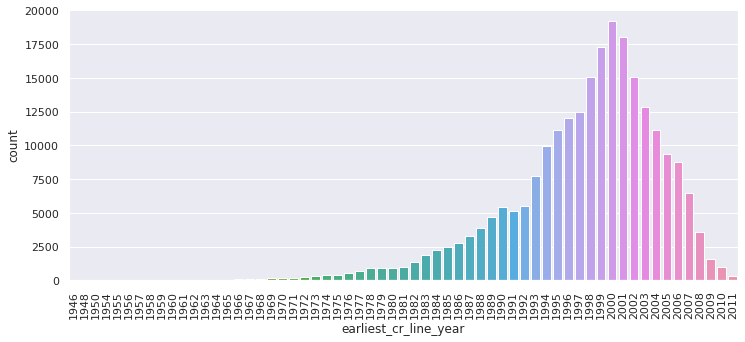

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(inter_df['earliest_cr_line_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

The distribution of `earlies_cr_line_year` is negatively skewed

#### Feature `last_pymnt_d_year`

In [ ]:
c = inter_df.groupby(['last_pymnt_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
c['%'] = round(c['total']*100/sum(c['total']),3)
c

,last_pymnt_d_year,total,%
0,2007,2,0.001
1,2008,335,0.140
2,2009,838,0.351
3,2010,2420,1.015
4,2011,5748,2.410
5,2012,11813,4.952
6,2013,27194,11.400
7,2014,66595,27.918
8,2015,119441,50.072
9,2016,4151,1.740


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


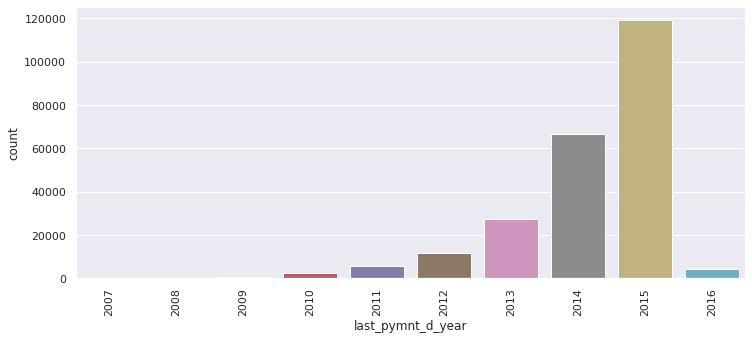

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(inter_df['last_pymnt_d_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

In the feature `last_pymnt_d_year` 50.072% of the total population is dominated by 2015 labels

#### Feature `next_pymnt_d_year`

In [ ]:
d = inter_df.groupby(['next_pymnt_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
d['%'] = round(d['total']*100/sum(d['total']),3)
d

,next_pymnt_d_year,total,%
0,2007,1,0.009
1,2008,105,0.898
2,2009,312,2.667
3,2010,515,4.402
4,2011,820,7.009
5,2012,472,4.035
6,2013,372,3.180
7,2014,63,0.539
8,2015,79,0.675
9,2016,8960,76.588


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


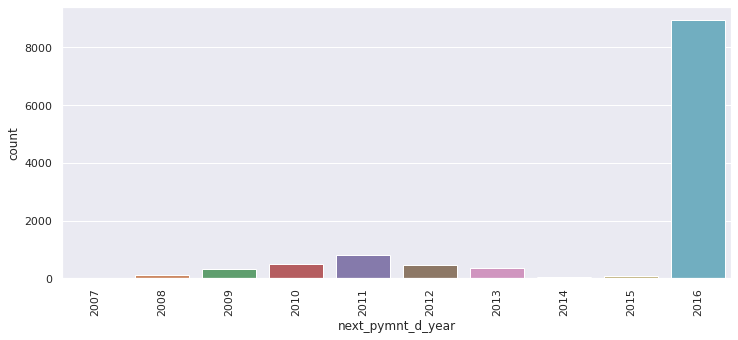

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(inter_df['next_pymnt_d_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

Feature `next_payment_d_year` 76.588% of the total population is dominated by the 2016 label

#### Feature `last_credit_pull_d_year`

In [ ]:
d = inter_df.groupby(['last_credit_pull_d_year']).agg({'id':'count'}).rename(columns={'id':'total'}).reset_index()
d['%'] = round(d['total']*100/sum(d['total']),3)
d

,last_credit_pull_d_year,total,%
0,2007,58,0.024
1,2008,62,0.026
2,2009,394,0.165
3,2010,1151,0.482
4,2011,2690,1.126
5,2012,5313,2.224
6,2013,12432,5.204
7,2014,31341,13.119
8,2015,83769,35.066
9,2016,101680,42.564


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


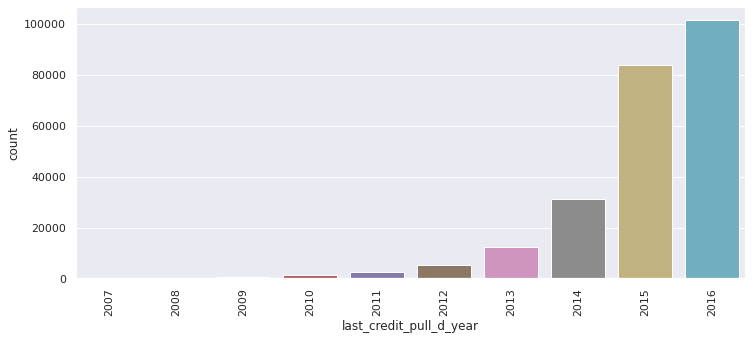

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(inter_df['last_credit_pull_d_year'].sort_values())
plt.xticks(rotation=90)
plt.show()

Feature `last_credit_pull_d_year` 42.564% of the total population is dominated by 2016 labels

### Univariate Analysis : Numerical Features

In [ ]:
print(nums1)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']


In [ ]:
len(nums1)

35

In [ ]:
temp = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 
        'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 
        'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
        'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
        'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
        'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 
        'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 
        'total_rev_hi_lim']

In [ ]:
len(temp)

32

#### Distribution of Numerical Features


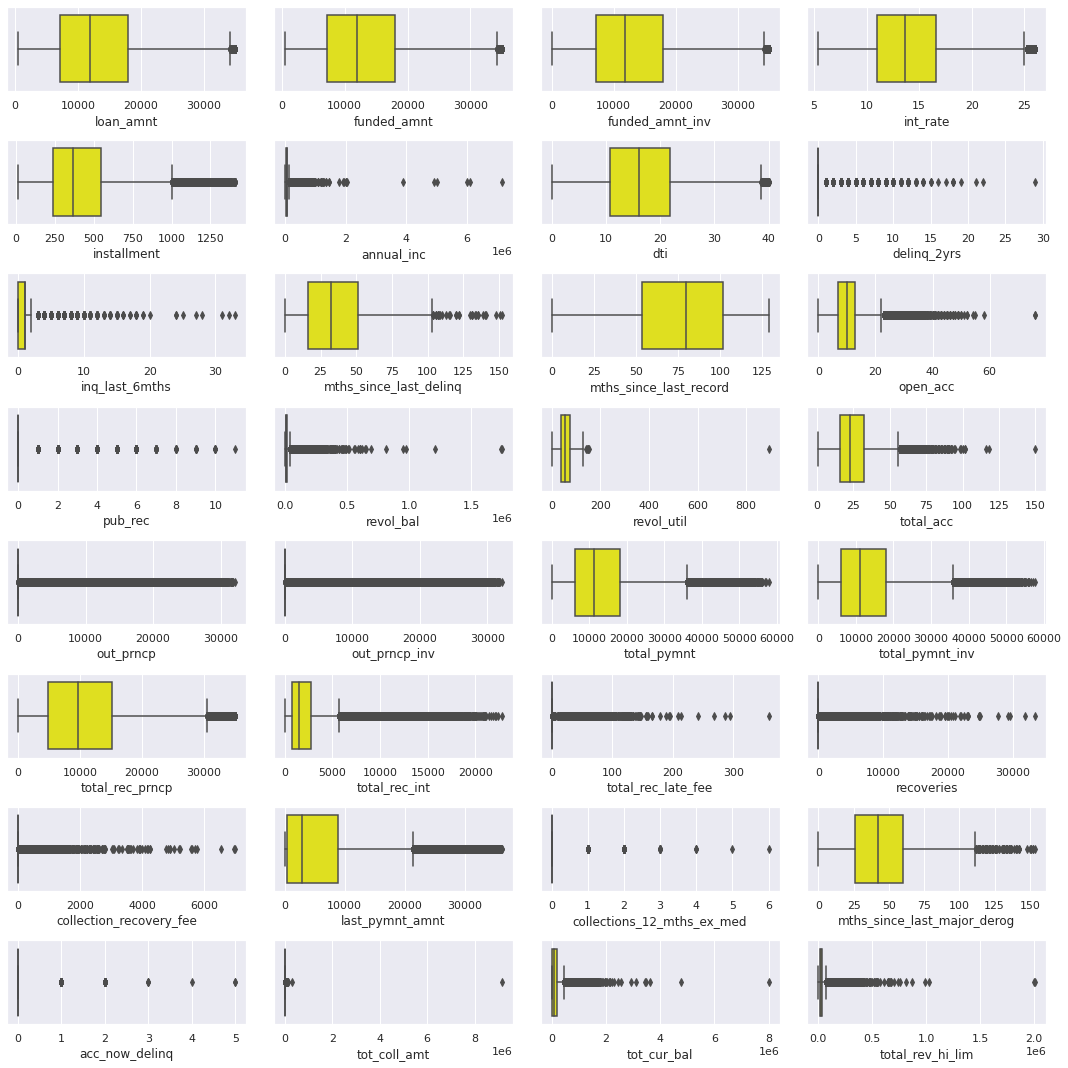

In [ ]:
plt.figure(figsize=(15,15))
for i in range(0, len(temp)):
    plt.subplot(8, 4, i+1)
    sns.boxplot(x=inter_df[temp[i]], color='yellow')
    plt.xlabel(temp[i])
    plt.tight_layout()

In [ ]:
inter_df[temp].columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')

**Observation:**
* Feature that has no outliers are `'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'dti',` and `'mths_since_last_record'`
* Feature `acc_now_delinq` is an ordinal data

### Bivariate Analysis : Categorical Features

In [ ]:
print(cats1)

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'final_status']


In [ ]:
temp = ['term', 'grade','emp_length', 'home_ownership', 'verification_status',
        'pymnt_plan', 'purpose', 'initial_list_status']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

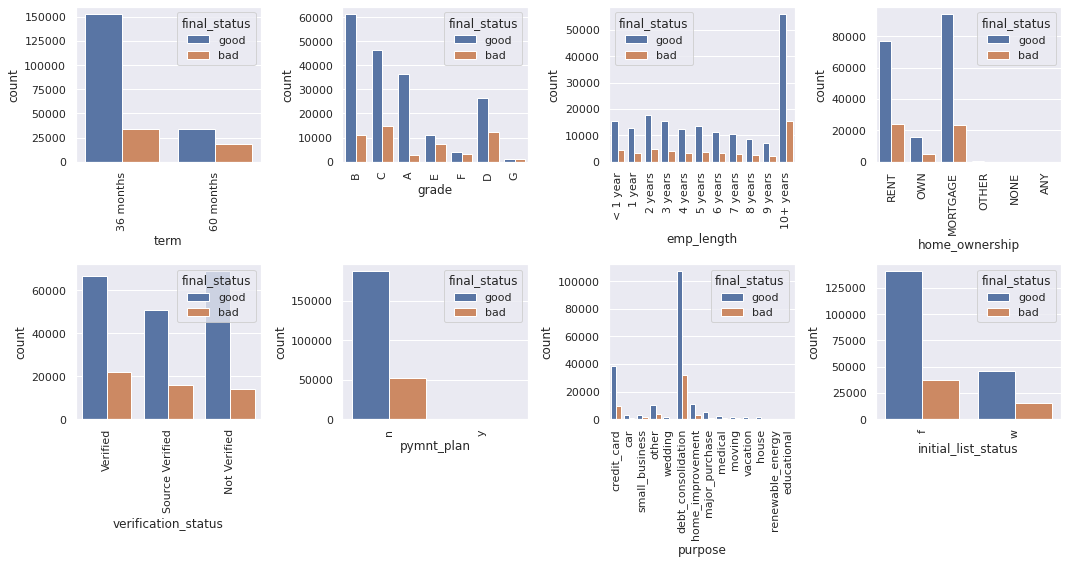

In [ ]:
plt.figure(figsize=(15,8))
for i in range(0, len(temp)):
    plt.subplot(2, 4, i+1)
    sns.countplot(inter_df[temp[i]], hue=inter_df['final_status'])
    plt.xlabel(temp[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observation:**
* In the `term` feature, the highest number of defaulted borrowers (bad loan) is in the `term = 36 months` category.
* The highest number of borrowers who defaulted (bad loan) on the `grade` feature were customers with `grade = C`
* The highest number of borrowers who defaulted (bad loan) on the `emp_length` feature were customers with more than 10 years of service. 
* Based on `home_ownership`, the highest number of defaulted borrowers are customers with `home_ownership` type 'RENT'. Meanwhile, for `home_ownership` with type `MORTAGE`, the number of borrowers who defaulted on average was quite the same.
* Based on `verification_status` the maximum number of borrowers who fail to pay is at 'Verified' status.
* Based on the `purpose` feature, the number of borrowers who fail to pay the most is in the loan destination for 'debt_consolidation'.
* Based on the `initial_list_status` feature, the maximum number of borrowers who fail to pay is category 'f'.

In [ ]:
temp = ['issue_d_year','last_pymnt_d_year','next_pymnt_d_year','last_credit_pull_d_year'] #'earliest_cr_line_year'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

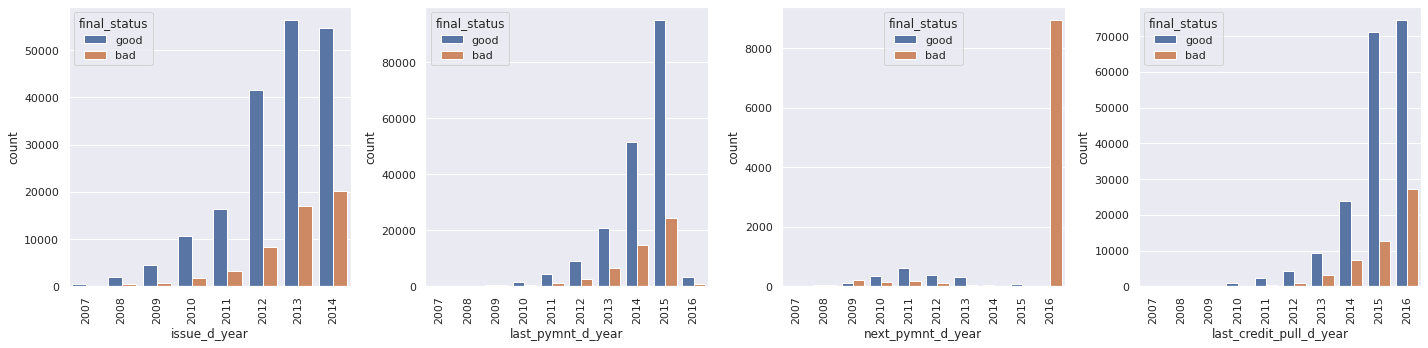

In [ ]:
plt.figure(figsize=(20,5))
for i in range(0, len(temp)):
    plt.subplot(1, 4, i+1)
    sns.countplot(inter_df[temp[i]].sort_values(), hue=inter_df['final_status'])
    plt.xlabel(temp[i])
    plt.xticks(rotation=90)
    plt.tight_layout()

**Observation:**
* In the `issue_d_year` feature, the number of borrowers who are in good loan and defaulted increases every year. The total number of borrowers who defaulted (bad loan) was highest in 2014.
* In the `last_pymnt_d_year` feature, the number of borrowers who are in good loan and defaulted increases every year. However, in 2016, the number of good loan and defaulted borrowers decreased significantly.
* In the feature `next_pymnt_d_year` the number of borrowers who defaulted was extremely high in 2016
* In the `last_credit_pull_d_year` feature, the number of borrowers who are able and defaulted increases every year.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


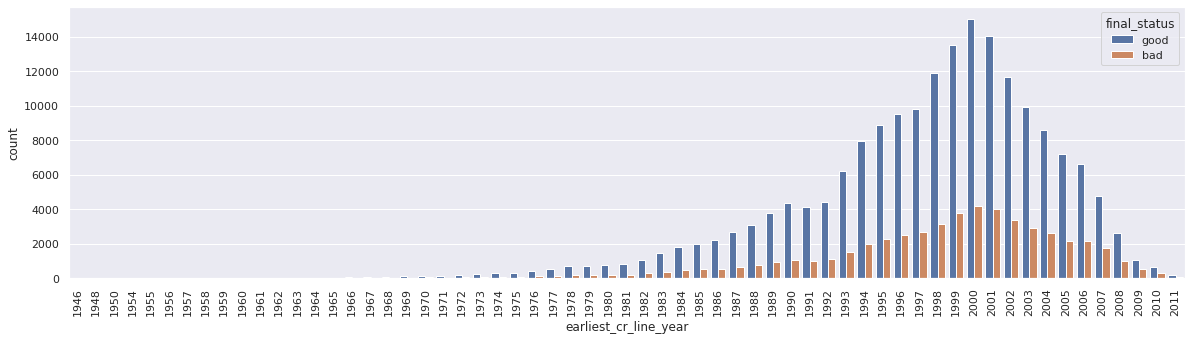

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(inter_df['earliest_cr_line_year'].sort_values(), hue=inter_df['final_status'])
plt.xticks(rotation=90)
plt.show()

In the `earliest_cr_line_year` feature, the number of borrowers who are able to pay is directly proportional to the number of those who fail to pay. If the number of borrowers who are able to pay increases, the number of defaulters will also increase.

### Bivariate Analysis : Numerical Features

In [ ]:
print(nums1)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'target']


In [ ]:
temp = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

In [ ]:
print(temp)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


In [ ]:
len(temp)

32

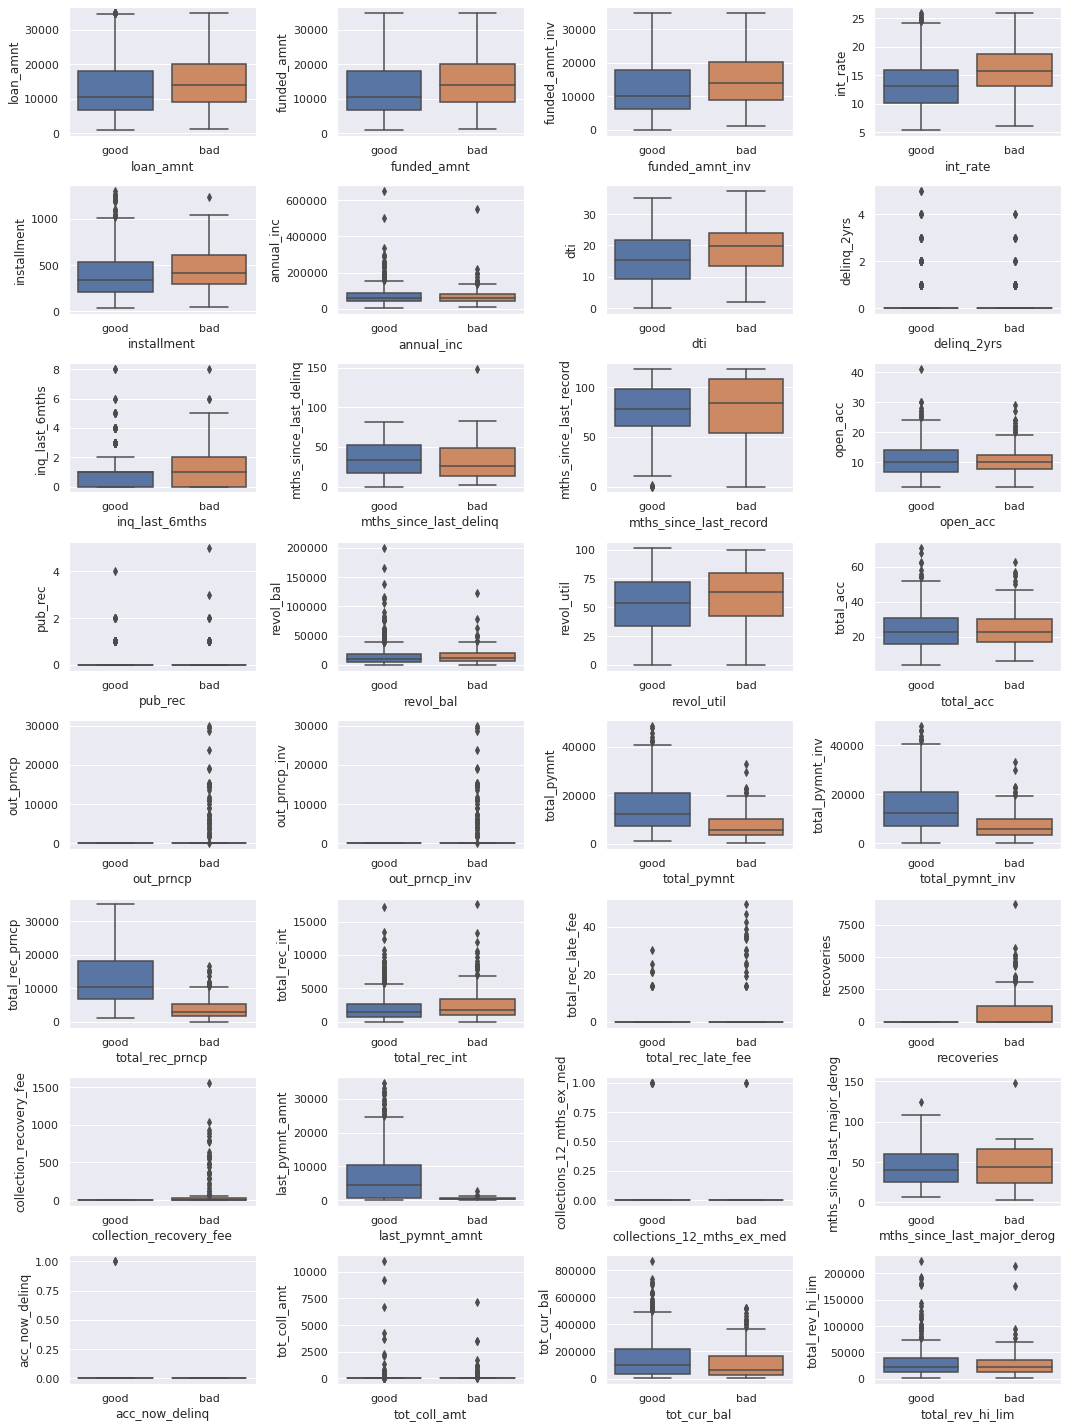

In [ ]:
df_sample=inter_df.sample(1000,random_state=1)
plt.figure(figsize=(15,20))
for i in range(0, len(temp)):
    plt.subplot(8, 4, i+1)
    sns.boxplot(y=df_sample[temp[i]], x=inter_df['final_status'])
    plt.xlabel(temp[i])
    plt.tight_layout()

**Observation:**
* Borrowers with a value of `total_rec_prncp` between 0 to 5000 are defaulters (bad loan). Meanwhile, borrowers with a `total_rec_prncp` value of more than 5000 are borrowers who are able to pay
* In the `total_rec_int` feature, capable and non-paying borrowers are in the same range, which is between 0 to 5000.
* Borrowers who default have a higher `total_rec_late_fee` value than borrowers who can afford to pay
* Borrowers with a value of `recoveries`> 0 are borrowers who fail to pay. While borrowers with `recoveries` = 0 are borrowers who are able to pay.
* Borrowers with `collection_recovery_fee` > 0 are borrowers who have defaulted. Meanwhile, borrowers with `collection_recovery_fee` = 0 are borrowers who can pay.
* In the `last_pymnt_amnt` feature the borrower whose last total payment (`last_pymnt_amnt`) < 10000 is the borrower who defaulted.
* Borrowers with a value of `mnth_since_Last_major_derog` between 0 to 75 are borrowers who have defaulted.
* Borrowers with a value of `tot_cur_bal` between 0 to 0.5 are borrowers who have defaulted.
* Borrowers with a value of `total_rev_hi_lim` between 0 to 150000 are borrowers who have defaulted.

### Multivariate Analysis

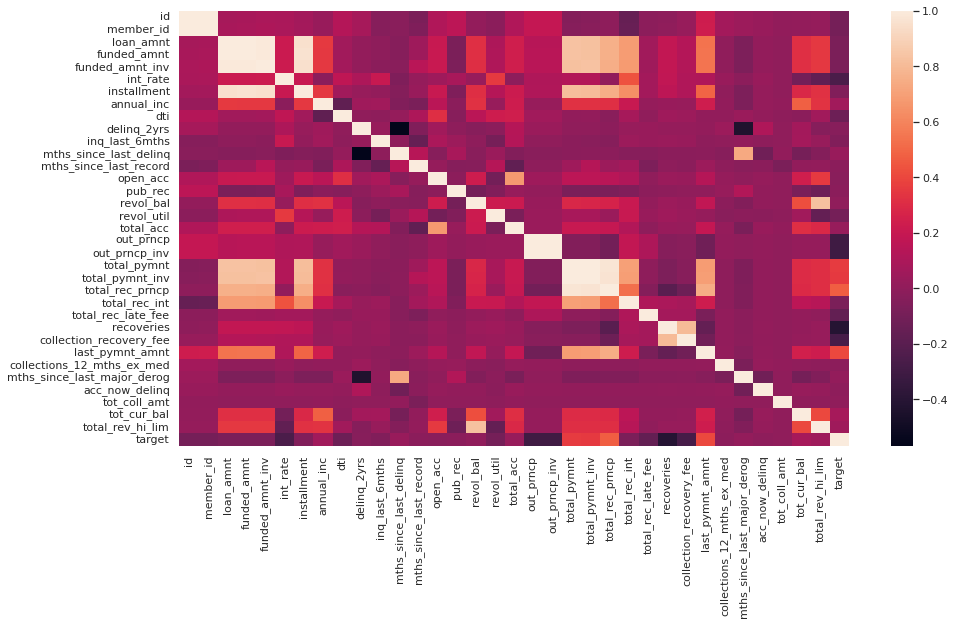

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(inter_df.corr(),fmt='2.f')
plt.show()

### Getting Insight from EDA

Calculating the remaining principal loan from each borrower

In [ ]:
inter_df[inter_df['final_status']=='bad'].head(1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,next_pymnt_d_month,next_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,Dec,2011,Apr,1999,Apr,2013,NaN,NaN,Sep,2013


In [ ]:
a = inter_df[inter_df['final_status']=='bad'][['loan_amnt','funded_amnt','term','int_rate','installment',
                       'out_prncp','out_prncp_inv','total_pymnt',
                       'total_pymnt_inv','total_rec_prncp','total_rec_int',
                       'total_rec_late_fee','recoveries','collection_recovery_fee']]
a['must_pymnt'] = np.where(a['term']=='60 months',a['installment']*60,a['installment']*36)
a.head(3)

,loan_amnt,funded_amnt,term,int_rate,installment,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,must_pymnt
1,2500,2500,60 months,15.27,59.83,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.11,3589.8
8,5600,5600,60 months,21.28,152.39,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.09,9143.4
9,5375,5375,60 months,12.69,121.45,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.52,7287.0


In [ ]:
#the rest amount to be paid by the borrower
a['dif'] = a['must_pymnt'] - (a['total_pymnt']+a['total_rec_late_fee']+a['collection_recovery_fee'])
a.head()

,loan_amnt,funded_amnt,term,int_rate,installment,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,must_pymnt,dif
1,2500,2500,60 months,15.27,59.83,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.1100,3589.80,2579.9800
8,5600,5600,60 months,21.28,152.39,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.0900,9143.40,8495.2900
9,5375,5375,60 months,12.69,121.45,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.5200,7287.00,5808.2900
12,9000,9000,36 months,13.49,305.38,0.0,0.0,2270.70,2270.70,1256.14,570.26,0.0,444.30,4.1600,10993.68,8718.8200
14,10000,10000,36 months,10.65,325.74,0.0,0.0,7471.99,7471.99,5433.47,1393.42,0.0,645.10,6.3145,11726.64,4248.3355


* `out_prncp`: Remaining loan principal for the total amount funded
* `out_prncp_inv`: Remaining loan principal for a portion of the total amount funded by investors
* `total_pymt`: Payments received to date for the total amount funded
* `total_rec_prncp`: Principal loan received to date
* `total_rec_int`: Interest received to date

In [ ]:
round(sum(a.dif),3)

687949073.469

In [ ]:
a.shape

(52186, 16)

Feature `must_pymnt` is the amount that must be paid by the borrower. The `dif` feature is the difference between `must_pymnt` and `total_pymnt` which means someone still has an obligation to pay as much as `dif`. The company will have a potential loss of $687,949,073,469 because 52186 borrowers are bad borrowers (cannot afford/default)

#### total_rec_prncp

In [ ]:
ma1 = inter_df.groupby(['final_status','purpose']).agg({'total_rec_prncp':'mean'}).reset_index().sort_values(['total_rec_prncp'],ascending=False)
ma1.columns = ['final_status','purpose','avg_total_rec_prncp']
ma1

,final_status,purpose,avg_total_rec_prncp
19,good,house,14990.679062
25,good,small_business,14285.165251
16,good,debt_consolidation,14019.061610
15,good,credit_card,13486.952256
18,good,home_improvement,12946.060260
27,good,wedding,9977.265716
24,good,renewable_energy,9296.657673
20,good,major_purchase,9195.949014
23,good,other,8879.590824
21,good,medical,8448.437220


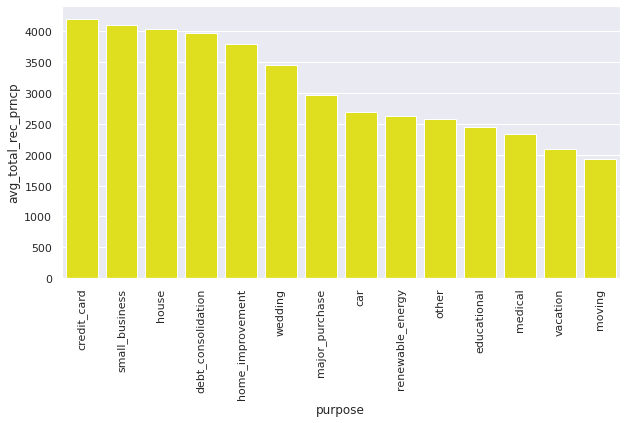

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='purpose',y=ma1['avg_total_rec_prncp'].sort_values(ascending=False),data=ma1[ma1['final_status']=='bad'],color='yellow')
plt.xticks(rotation=90)
plt.show()

Based on defaulted borrowers. The highest average total rec prncp with loan purposes for `credit_card`.
The average `total_rec_prncp` borrowers who are able to pay are higher than those who default.

In [ ]:
ma2 = inter_df.groupby(['final_status','grade']).agg({'total_rec_prncp':'mean'}).reset_index().sort_values(['total_rec_prncp'],ascending=False)
ma2.columns = ['final_status','grade','avg_total_rec_prncp']
ma2

,final_status,grade,avg_total_rec_prncp
13,good,G,20059.225860
12,good,F,18227.805609
11,good,E,16911.452255
10,good,D,13823.903535
9,good,C,13138.804326
8,good,B,12267.539812
7,good,A,12060.671232
0,bad,A,4701.058751
1,bad,B,4490.793155
2,bad,C,3856.203401


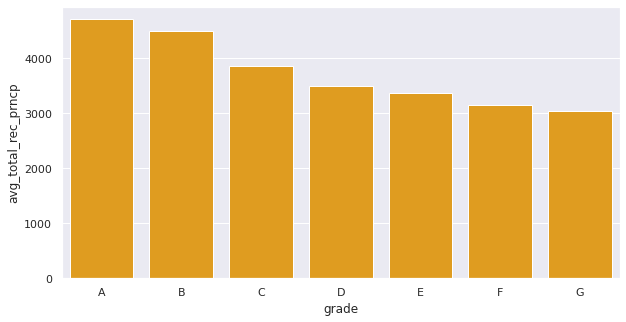

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='grade',y='avg_total_rec_prncp',data=ma2[ma2['final_status']=='bad'],color='orange')
plt.show()

In [ ]:
ma3 = inter_df.groupby(['final_status','grade','purpose']).agg({'total_rec_prncp':'mean'}).reset_index()
ma3.columns = ['final_status','grade','purpose','avg_total_rec_prncp']
ma3[ma3['final_status']=='bad'].sort_values(['avg_total_rec_prncp'],ascending=False)

,final_status,grade,purpose,avg_total_rec_prncp
5,bad,A,house,5328.207222
4,bad,A,home_improvement,5190.776949
1,bad,A,credit_card,5140.611438
2,bad,A,debt_consolidation,5001.268284
25,bad,B,small_business,4916.038701
...,...,...,...,...
64,bad,E,moving,1494.051442
92,bad,G,moving,1272.463333
59,bad,E,educational,1263.698667
84,bad,G,car,1250.412857


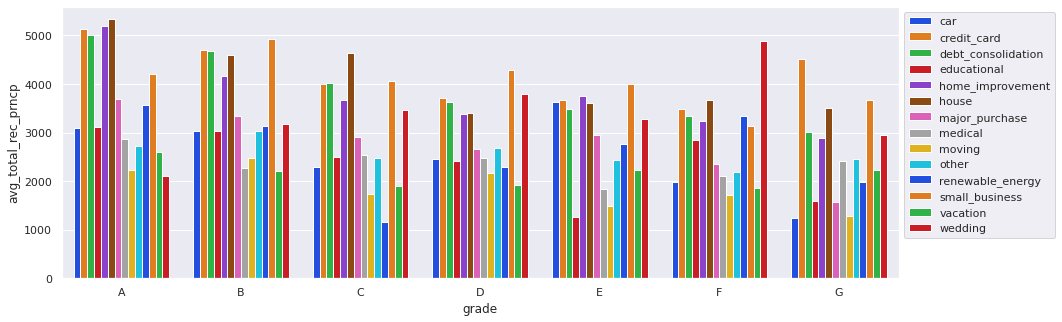

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_total_rec_prncp',hue='purpose',data=ma3[ma3['final_status']=='bad'],palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

If the defaulting borrower is reviewed from `grade`,` purpose`, and average `total_rec_prncp`, the borrower is in the `grade` A category with the purpose of borrowing a house. The second and third positions are also in the `grade` A category with the purpose of loans for `home_imporvement` and credit cards, respectively. So it can be concluded that, to reduce defaulting borrowers can consider rejecting borrowers who are in `grade` A.

In [ ]:
inter_df.groupby('target').agg({'total_rec_prncp':'mean'})

,total_rec_prncp
target,
0,3829.815241
1,13110.606855


#### `collection_recovery_fee`

In [ ]:
ma4 = inter_df.groupby(['final_status','purpose']).agg({'collection_recovery_fee':'mean'}).reset_index().sort_values(['collection_recovery_fee'],ascending=False)
ma4.columns = ['final_status','purpose','avg_collection_recovery_fee']
ma4[ma4['final_status']=='bad']

,final_status,purpose,avg_collection_recovery_fee
10,bad,renewable_energy,146.028452
3,bad,educational,132.148825
13,bad,wedding,109.072855
11,bad,small_business,107.501345
4,bad,home_improvement,86.553666
2,bad,debt_consolidation,83.727046
5,bad,house,76.077878
1,bad,credit_card,75.756100
6,bad,major_purchase,66.479359
7,bad,medical,59.418772


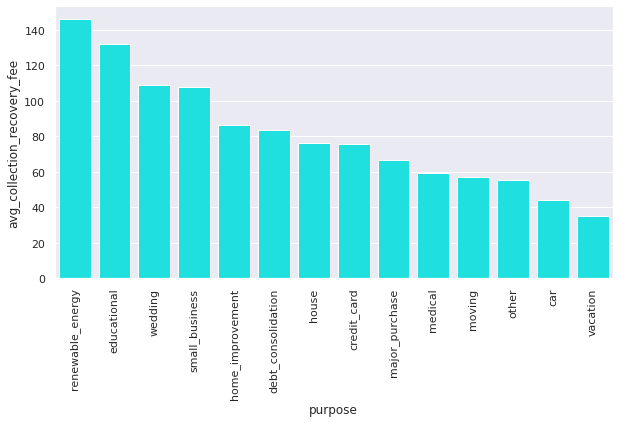

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='purpose',y=ma4['avg_collection_recovery_fee'].sort_values(ascending=False),data=ma4[ma4['final_status']=='bad'],color='cyan')
plt.xticks(rotation=90)
plt.show()

In [ ]:
ma5 = inter_df.groupby(['final_status','grade']).agg({'collection_recovery_fee':'mean'}).reset_index().sort_values(['collection_recovery_fee'],ascending=False)
ma5.columns = ['final_status','grade','avg_collection_recovery_fee']
ma5[ma5['final_status']=='bad']

,final_status,grade,avg_collection_recovery_fee
6,bad,G,165.448684
5,bad,F,139.301832
4,bad,E,109.313649
3,bad,D,82.809374
2,bad,C,69.815587
1,bad,B,55.326875
0,bad,A,48.837291


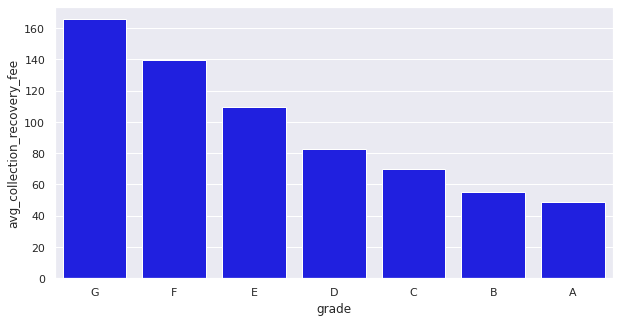

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='grade',y='avg_collection_recovery_fee',data=ma5[ma5['final_status']=='bad'],color='blue')
plt.show()

In [ ]:
ma6 = inter_df.groupby(['final_status','grade','purpose']).agg({'collection_recovery_fee':'mean'}).reset_index()
ma6.columns = ['final_status','grade','purpose','avg_collection_recovery_fee']
ma6[ma6['final_status']=='bad']

,final_status,grade,purpose,avg_collection_recovery_fee
0,bad,A,car,34.856877
1,bad,A,credit_card,61.027500
2,bad,A,debt_consolidation,49.153024
3,bad,A,educational,139.069080
4,bad,A,home_improvement,35.196451
...,...,...,...,...
93,bad,G,other,119.172054
94,bad,G,renewable_energy,490.346133
95,bad,G,small_business,232.557967
96,bad,G,vacation,179.743267


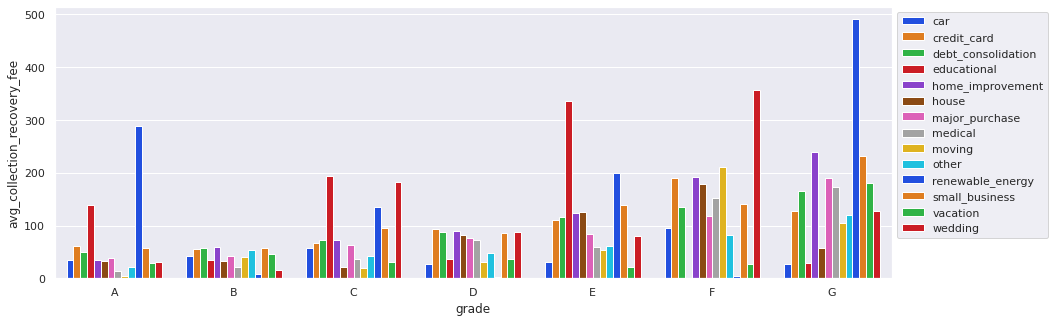

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_collection_recovery_fee',hue='purpose',data=ma6[ma6['final_status']=='bad'],palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

If a borrower who defaults is reviewed from the feature `grade`, `purpose`, and average `collection_recovery_fee`, then the borrower at the highest risk of default is in the `grade` G category with the aim of borrowing for renewable energy. In the second highest position, the risk of borrowers defaulting is in the `grade` F category with the purpose of borrowing for marriage. In the third highest position, the risk of borrowers who will default is in the `grade` G category with the aim of borrowing for home improvements. So that it can be considered for borrowers in that category to be refused credit loans.

`recoveries`

In [ ]:
ma7 = inter_df.groupby(['final_status','purpose']).agg({'recoveries':'mean'}).reset_index().sort_values(['recoveries'],ascending=False)
ma7.columns = ['final_status','purpose','avg_recoveries']
ma7[ma7['final_status']=='bad']

,final_status,purpose,avg_recoveries
10,bad,renewable_energy,1021.842593
11,bad,small_business,1008.781593
5,bad,house,990.171677
13,bad,wedding,879.170140
4,bad,home_improvement,825.340629
2,bad,debt_consolidation,799.265856
1,bad,credit_card,706.093851
6,bad,major_purchase,672.312389
9,bad,other,567.148954
7,bad,medical,520.645337


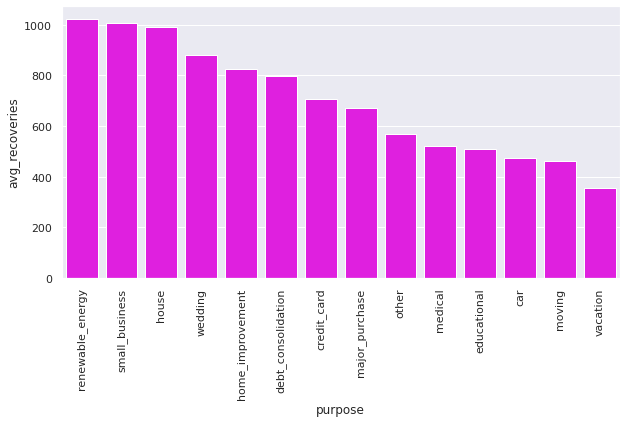

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='purpose',y=ma7['avg_recoveries'].sort_values(ascending=False),data=ma7[ma7['final_status']=='bad'],color='magenta')
plt.xticks(rotation=90)
plt.show()

* When viewed based on the average `recoveries` and the purpose of the loan (`purpose`), borrowers in the `renewable_energy` category have the highest average recoveries, which means that borrowers in this category tend to default (bad debt). So to reduce defaulting borrowers, it can be reviewed or rejected if the user makes a loan for the purpose of `renewable_energy` because of the risk of credit default.

In [ ]:
ma8 = inter_df.groupby(['final_status','grade']).agg({'recoveries':'mean'}).reset_index().sort_values(['recoveries'],ascending=False)
ma8.columns = ['final_status','grade','avg_recoveries']
ma8[ma8['final_status']=='bad']

,final_status,grade,avg_recoveries
6,bad,G,1423.852622
5,bad,F,1363.703600
4,bad,E,1059.407706
3,bad,D,771.873695
2,bad,C,651.149996
1,bad,B,554.666924
0,bad,A,461.954499


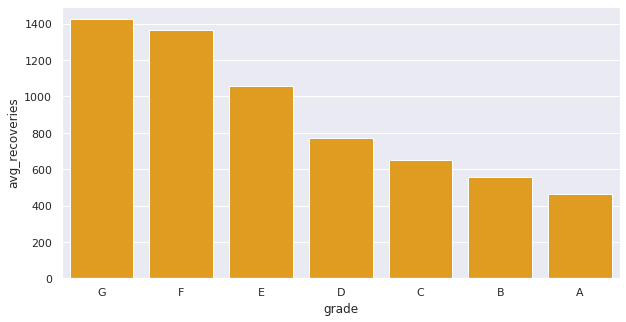

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='grade',y='avg_recoveries',data=ma8[ma8['final_status']=='bad'],color='orange')
plt.show()

In [ ]:
ma9 = inter_df.groupby(['final_status','grade','purpose']).agg({'recoveries':'mean','annual_inc':'mean','dti':'mean'}).reset_index()
ma9.columns = ['final_status','grade','purpose','avg_recoveries','avg_annual_inc','avg_dti']
ma9[ma9['final_status']=='bad']

,final_status,grade,purpose,avg_recoveries,avg_annual_inc,avg_dti
0,bad,A,car,298.130763,52093.377143,12.735571
1,bad,A,credit_card,510.306781,70962.217863,16.799644
2,bad,A,debt_consolidation,468.770374,68308.022194,16.845612
3,bad,A,educational,808.816000,69809.200000,5.644000
4,bad,A,home_improvement,433.655480,77425.383729,13.524124
...,...,...,...,...,...,...
93,bad,G,other,1216.405242,78994.572581,17.248629
94,bad,G,renewable_energy,3941.606667,96129.271667,17.611667
95,bad,G,small_business,1791.611304,103633.402174,13.896304
96,bad,G,vacation,1743.746667,115666.666667,16.530000


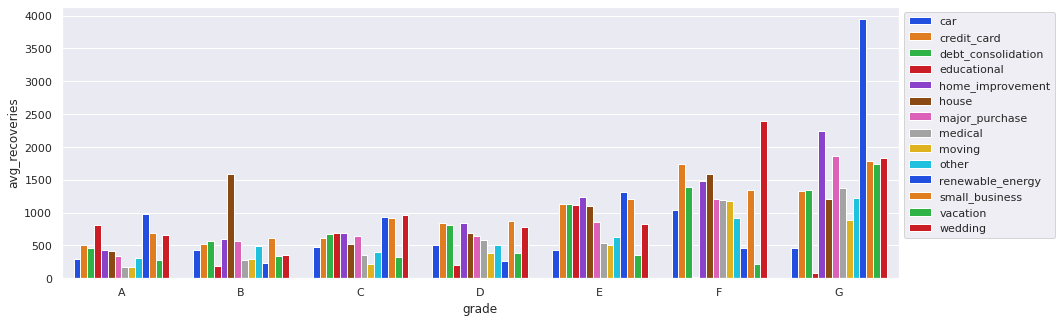

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_recoveries',hue='purpose',data=ma9[ma9['final_status']=='bad'],palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

If borrowers fail to pay in terms of feature 'grade', 'purpose', and average 'recoveries' value, then borrowers who are in the 'grade' G category with the aim of renewable energy need to be considered for rejection of credit applications because they have credit risk failed to pay. Likewise, borrowers who are in the 'grade' F category with the purpose of 'wedding' lending also need to be considered for refusal of credit applications because they have the risk of default. Likewise, 'grade' B with the aim of borrowing 'house' has a credit default risk so that it can be considered to reject the credit application.

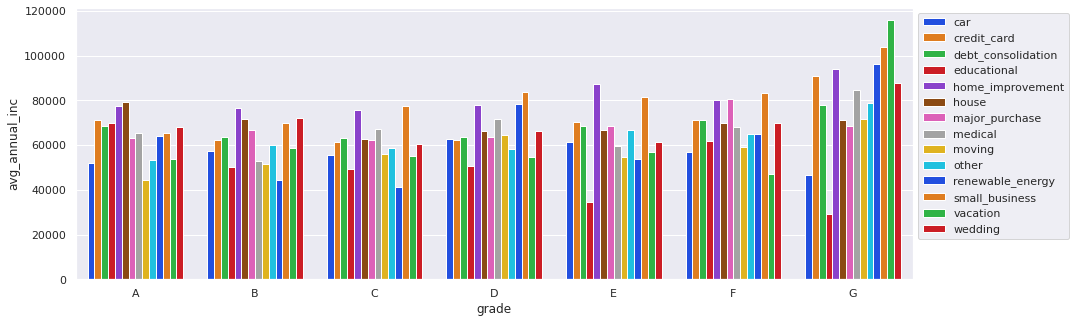

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='grade',y='avg_annual_inc',hue='purpose',data=ma9[ma9['final_status']=='bad'],palette='bright')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
z = inter_df[inter_df['final_status']=='bad'][['grade','purpose','dti','recoveries','annual_inc']]
zg = z.groupby(['grade','purpose']).agg({'dti':'mean','recoveries':'mean'}).reset_index().sort_values(['grade','recoveries'],ascending=[True,False])
zg[zg['grade']=='G']

,grade,purpose,dti,recoveries
94,G,renewable_energy,17.611667,3941.606667
88,G,home_improvement,15.564082,2240.982449
90,G,major_purchase,21.826667,1860.398889
97,G,wedding,17.020000,1830.858571
95,G,small_business,13.896304,1791.611304
96,G,vacation,16.530000,1743.746667
91,G,medical,16.391333,1377.364000
86,G,debt_consolidation,20.204785,1338.468505
85,G,credit_card,19.789167,1336.894333
93,G,other,17.248629,1216.405242


<AxesSubplot:xlabel='dti', ylabel='recoveries'>

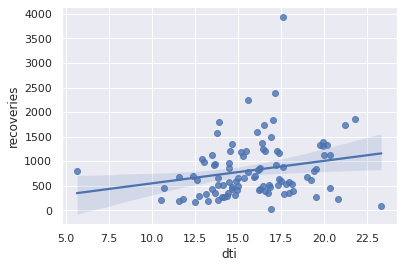

In [ ]:
sns.regplot(x='dti',y='recoveries',data=zg)

### Cleaning Data

#### Checking Missing Values

In [ ]:
#checking missing values percentage
mval = inter_df.isnull().sum().sort_values(ascending=False).reset_index()
mval.columns = ['feature','null']
mval['%'] = round(mval['null']*100/(inter_df.shape[0]),3)
mval = mval[mval['%']>0]
mval

,feature,null,%
0,next_pymnt_d,227214,95.103
1,next_pymnt_d_year,227214,95.103
2,next_pymnt_d_month,227214,95.103
3,mths_since_last_record,209964,87.883
4,mths_since_last_major_derog,196369,82.193
5,mths_since_last_delinq,133528,55.890
6,tot_cur_bal,66623,27.886
7,total_rev_hi_lim,66623,27.886
8,tot_coll_amt,66623,27.886
9,emp_length,9225,3.861


In [ ]:
#filtering features that have missing values percentage higher than 40%
mval1 = list(mval['feature'][mval['%']>40])
print("Features with >40% Missing Values Percentage : ", mval1)
#filtering features that have missing values percentage lower than 40%
mval2 = list(mval['feature'][mval['%']<40])
print("Features with <40% Missing Values Percentage : ", mval2)

Features with >40% Missing Values Percentage :  ['next_pymnt_d', 'next_pymnt_d_year', 'next_pymnt_d_month', 'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq']
Features with <40% Missing Values Percentage :  ['tot_cur_bal', 'total_rev_hi_lim', 'tot_coll_amt', 'emp_length', 'last_pymnt_d_month', 'last_pymnt_d_year', 'last_pymnt_d', 'revol_util', 'collections_12_mths_ex_med', 'inq_last_6mths', 'earliest_cr_line', 'delinq_2yrs', 'acc_now_delinq', 'total_acc', 'pub_rec', 'earliest_cr_line_month', 'earliest_cr_line_year', 'open_acc', 'last_credit_pull_d', 'last_credit_pull_d_year', 'last_credit_pull_d_month', 'annual_inc']


#### Handling Missing Values

For features that have missing(null) values > 40%, the features can be dropped as it's no longer representative. If we do imputation, we need to change much data, which is inefficient<br><br>
For features that have null values percentage < 20%, the null values will be filled with the median (for numeric data) and mode (for categorical data) values.

In [ ]:
# dimension before dropping
inter_df.shape

(238913, 61)

In [ ]:
# drop features that has missing values percentage >40%
inter_df.drop(columns=mval1,inplace=True)

In [ ]:
# dimension after dropping
inter_df.shape

(238913, 55)

In [ ]:
temp1 = []
temp2 = []
for i in mval2:
  if (inter_df[i].dtype == 'object') or (inter_df[i].dtype =='category'):
    temp2.append(i)
  else:
    temp1.append(i)

In [ ]:
#check statistical summary from feature on list mval2
inter_df[temp1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tot_cur_bal,172290.0,136567.825405,150180.174704,0.0,27954.0,79239.0,206402.5,8000078.0
total_rev_hi_lim,172290.0,29101.029839,28544.950606,0.0,13200.0,22000.0,36200.0,2013133.0
tot_coll_amt,172290.0,200.963654,22110.090058,0.0,0.0,0.0,0.0,9152545.0
revol_util,238681.0,54.995834,24.671291,0.0,37.3,56.7,74.5,892.3
collections_12_mths_ex_med,238768.0,0.005939,0.083821,0.0,0.0,0.0,0.0,6.0
inq_last_6mths,238884.0,0.906859,1.173756,0.0,0.0,1.0,1.0,33.0
delinq_2yrs,238884.0,0.248300,0.735872,0.0,0.0,0.0,0.0,29.0
acc_now_delinq,238884.0,0.002897,0.058517,0.0,0.0,0.0,0.0,5.0
total_acc,238884.0,24.812034,11.664663,1.0,16.0,23.0,32.0,150.0
pub_rec,238884.0,0.134932,0.421437,0.0,0.0,0.0,0.0,11.0


Since most of the features that have a null values are skewed, the value to fill in the null value is the median value of each feature.

#### Imputation

In [ ]:
for i in temp1:
  inter_df[i].fillna(inter_df[i].median(),inplace=True)

In [ ]:
#checking null values
inter_df[temp1].isnull().sum()

tot_cur_bal                   0
total_rev_hi_lim              0
tot_coll_amt                  0
revol_util                    0
collections_12_mths_ex_med    0
inq_last_6mths                0
delinq_2yrs                   0
acc_now_delinq                0
total_acc                     0
pub_rec                       0
open_acc                      0
annual_inc                    0
dtype: int64

In [ ]:
inter_df[temp2].describe().transpose()

,count,unique,top,freq
emp_length,229688,11,10+ years,71312
last_pymnt_d_month,238537,12,Oct,23938
last_pymnt_d_year,238537,10,2015,119441
last_pymnt_d,238537,98,Jul-15,11703
earliest_cr_line,238884,634,Oct-00,2033
earliest_cr_line_month,238884,12,Oct,23425
earliest_cr_line_year,238884,61,2000,19171
last_credit_pull_d,238890,103,Jan-16,101680
last_credit_pull_d_year,238890,10,2016,101680
last_credit_pull_d_month,238890,12,Jan,108838


For the categorical data, the null value for each feature is filled with the mode.

In [ ]:
inter_df['emp_length'] = inter_df['emp_length'].fillna('10+ years')
inter_df['last_pymnt_d'] = inter_df['last_pymnt_d'].fillna('Jan-16')
inter_df['last_pymnt_d_month'] = inter_df['last_pymnt_d_month'].fillna('Jan')
inter_df['last_pymnt_d_year'] = inter_df['last_pymnt_d_year'].fillna('2016')
inter_df['last_credit_pull_d'] = inter_df['last_credit_pull_d'].fillna('Jan-16')
inter_df['last_credit_pull_d_month'] = inter_df['last_credit_pull_d_month'].fillna('Jan')
inter_df['last_credit_pull_d_year'] = inter_df['last_credit_pull_d_year'].fillna('2016')
inter_df['earliest_cr_line'] = inter_df['earliest_cr_line'].fillna('Oct-00')
inter_df['earliest_cr_line_month'] = inter_df['earliest_cr_line_month'].fillna('Oct')
inter_df['earliest_cr_line_year'] = inter_df['earliest_cr_line_year'].fillna('2000')

In [ ]:
inter_df[temp2].isnull().sum()

emp_length                  0
last_pymnt_d_month          0
last_pymnt_d_year           0
last_pymnt_d                0
earliest_cr_line            0
earliest_cr_line_month      0
earliest_cr_line_year       0
last_credit_pull_d          0
last_credit_pull_d_year     0
last_credit_pull_d_month    0
dtype: int64

In [ ]:
#recheck
inter_df.isnull().sum().sum()

0

#### Checking for Duplicated Data

In [ ]:
inter_df.duplicated().any()

False

If return false, the data doesn't have duplicate values

### Data Preprocessing

In [ ]:
inter_df.shape

(238913, 55)

#### Feature Engineering : Date

Converting string into datetime

In [ ]:
inter_df[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].head()

,issue_d,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,Dec-11,Jan-15,Jan-16,Jan-85
1,Dec-11,Apr-13,Sep-13,Apr-99
2,Dec-11,Jun-14,Jan-16,Nov-01
3,Dec-11,Jan-15,Jan-15,Feb-96
5,Dec-11,Jan-15,Sep-15,Nov-04


In [ ]:
inter_df[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   issue_d             238913 non-null  object
 1   last_pymnt_d        238913 non-null  object
 2   last_credit_pull_d  238913 non-null  object
 3   earliest_cr_line    238913 non-null  object
dtypes: object(4)
memory usage: 17.2+ MB


In [ ]:
from datetime import datetime as dt

In [ ]:
inter_df['issue_d'] = pd.to_datetime(inter_df['issue_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
inter_df['last_pymnt_d'] = pd.to_datetime(inter_df['last_pymnt_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
inter_df['last_credit_pull_d'] = pd.to_datetime(inter_df['last_credit_pull_d'].apply(lambda x: dt.strptime(x, '%b-%y')))
inter_df['earliest_cr_line'] = pd.to_datetime(inter_df['earliest_cr_line'].apply(lambda x: dt.strptime(x, '%b-%y')))

In [ ]:
inter_df[['last_pymnt_d','last_credit_pull_d','earliest_cr_line']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   last_pymnt_d        238913 non-null  datetime64[ns]
 1   last_credit_pull_d  238913 non-null  datetime64[ns]
 2   earliest_cr_line    238913 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 15.4 MB


In [ ]:
inter_df[['issue_d','last_pymnt_d','last_credit_pull_d','earliest_cr_line']].head()

,issue_d,last_pymnt_d,last_credit_pull_d,earliest_cr_line
0,2011-12-01,2015-01-01,2016-01-01,1985-01-01
1,2011-12-01,2013-04-01,2013-09-01,1999-04-01
2,2011-12-01,2014-06-01,2016-01-01,2001-11-01
3,2011-12-01,2015-01-01,2015-01-01,1996-02-01
5,2011-12-01,2015-01-01,2015-09-01,2004-11-01


#### Vanishing Unused Features

In [ ]:
data_stat = pd.DataFrame()
data_stat.index = inter_df.columns
data_stat["unique_value"] = inter_df.nunique()
data_stat["missing_rate"] = inter_df.isna().mean()
data_stat["dtype"] = inter_df.dtypes
data_stat

,unique_value,missing_rate,dtype
id,238913,0.0,int64
member_id,238913,0.0,int64
loan_amnt,1310,0.0,int64
funded_amnt,1313,0.0,int64
funded_amnt_inv,9560,0.0,float64
term,2,0.0,object
int_rate,505,0.0,float64
installment,43848,0.0,float64
grade,7,0.0,object
sub_grade,35,0.0,category


#### Removing too unique features

In [ ]:
# Numerical Columns with too unique value
vari_col = data_stat[data_stat["unique_value"] == inter_df.shape[0]].index.to_list()
print("Columns with too unique value : ")
print(vari_col)
print()

# Categorical Columns with too much categories
cat_col_stat = data_stat[data_stat["dtype"] == "object"]
vari_cat_col = cat_col_stat[cat_col_stat["unique_value"] > 1000].index.to_list()
print("Columns with too much categories : ")
print(vari_cat_col)
print()

removed_features = vari_col + vari_cat_col

Columns with too unique value : 
['id', 'member_id']

Columns with too much categories : 
[]



In [ ]:
# Removing too unique columns
inter_df = inter_df.loc[:, ~inter_df.columns.isin(removed_features)].copy()
inter_df.shape

(238913, 53)

In [ ]:
# Columns with categorical type
cat_features = inter_df.select_dtypes(include=object).columns
cat_features

Index(['term', 'grade', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'final_status',
       'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year',
       'last_credit_pull_d_year'],
      dtype='object')

### Columns with date values

In [ ]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d"]

for col in date_cols:
    print(inter_df[col].value_counts().iloc[:5])
    print()

2014-10-01    9884
2014-07-01    9355
2014-04-01    7182
2013-11-01    6948
2013-12-01    6936
Name: issue_d, dtype: int64

2000-10-01    2062
1999-10-01    1890
2000-11-01    1856
2001-10-01    1848
1999-11-01    1819
Name: earliest_cr_line, dtype: int64

2015-07-01    11703
2015-10-01    11248
2015-09-01    10204
2015-12-01    10097
2015-03-01    10087
Name: last_pymnt_d, dtype: int64

2016-01-01    101703
2015-12-01     13779
2015-11-01      8238
2015-09-01      7982
2015-10-01      7848
Name: last_credit_pull_d, dtype: int64



There is no strong correlation between dates and each date has little correlation with loan status. However, we will remove the date feature that correlates less than 0.1 with the loan status

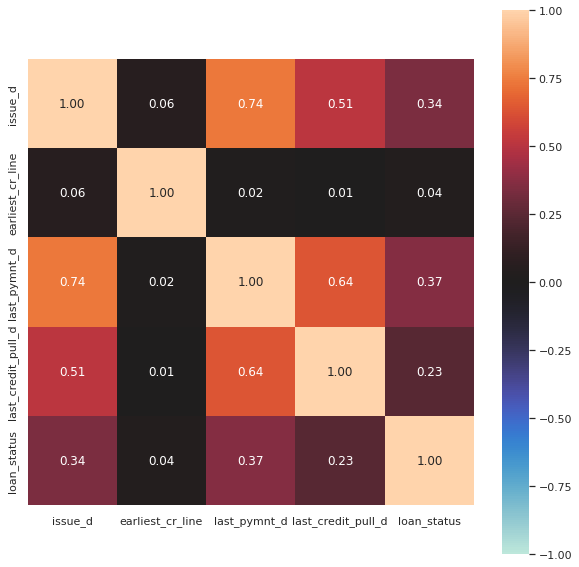

In [ ]:
# Correlation between date and loan status
used_cols = date_cols + ["loan_status"] 
complete_correlation = associations(
    inter_df[used_cols], 
    filename='date_correlation.png',
    figsize=(10,10)
)

In [ ]:
# Date features will be used
aff_date_cols = ["issue_d", "last_pymnt_d", "last_credit_pull_d"]
aff_date_cols

['issue_d', 'last_pymnt_d', 'last_credit_pull_d']

In [ ]:
# Remove date features that don't have a strong correlation with loan status
unused_cols = ["earliest_cr_line"]
inter_df = inter_df.drop(columns=unused_cols, errors="ignore")
inter_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,final_status,target,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,good,1,Dec,2011,Jan,1985,Jan,2015,Jan,2016
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,bad,0,Dec,2011,Apr,1999,Apr,2013,Sep,2013
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,good,1,Dec,2011,Nov,2001,Jun,2014,Jan,2016
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,good,1,Dec,2011,Feb,1996,Jan,2015,Jan,2015
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,...,good,1,Dec,2011,Nov,2004,Jan,2015,Sep,2015


In [ ]:
inter_df.shape

(238913, 52)

### Unused Categorical Columns

In [ ]:
other_cat_cols = cat_features[~cat_features.isin(date_cols)]
other_cat_cols

Index(['term', 'grade', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'final_status',
       'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year',
       'last_credit_pull_d_year'],
      dtype='object')

In [ ]:
inter_df.loc[:, other_cat_cols].head()

,term,grade,home_ownership,verification_status,loan_status,pymnt_plan,purpose,initial_list_status,final_status,issue_d_year,earliest_cr_line_year,last_pymnt_d_year,last_credit_pull_d_year
0,36 months,B,RENT,Verified,Fully Paid,n,credit_card,f,good,2011,1985,2015,2016
1,60 months,C,RENT,Source Verified,Charged Off,n,car,f,bad,2011,1999,2013,2013
2,36 months,C,RENT,Not Verified,Fully Paid,n,small_business,f,good,2011,2001,2014,2016
3,36 months,C,RENT,Source Verified,Fully Paid,n,other,f,good,2011,1996,2015,2015
5,36 months,A,RENT,Source Verified,Fully Paid,n,wedding,f,good,2011,2004,2015,2015


Some unused categorical columns are:
- sub_grade because it already has a similar column, namely grade

In [ ]:
unused_cols = ["sub_grade"]
inter_df = inter_df.drop(columns=unused_cols, errors="ignore")
inter_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,final_status,target,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,...,good,1,Dec,2011,Jan,1985,Jan,2015,Jan,2016
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,...,bad,0,Dec,2011,Apr,1999,Apr,2013,Sep,2013
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,...,good,1,Dec,2011,Nov,2001,Jun,2014,Jan,2016
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,...,good,1,Dec,2011,Feb,1996,Jan,2015,Jan,2015
5,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,...,good,1,Dec,2011,Nov,2004,Jan,2015,Sep,2015


In [ ]:
inter_df.shape

(238913, 51)

In [ ]:
other_cat_cols = cat_features[~cat_features.isin(date_cols + unused_cols)]
other_cat_cols

Index(['term', 'grade', 'home_ownership', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'initial_list_status', 'final_status',
       'issue_d_year', 'earliest_cr_line_year', 'last_pymnt_d_year',
       'last_credit_pull_d_year'],
      dtype='object')

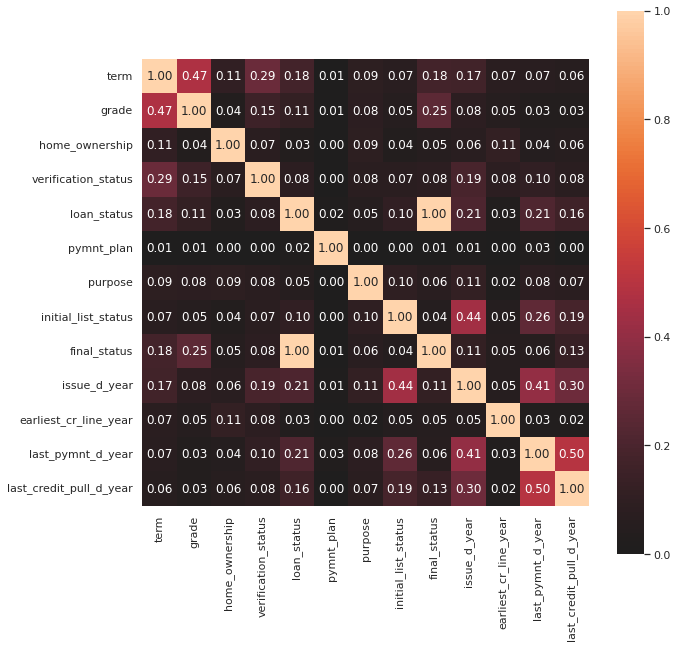

In [ ]:
# Correlation between categorical features and loan status
used_cols = other_cat_cols.to_list()
complete_correlation = associations(
    inter_df[used_cols], 
    filename='cat_correlation.png',
    figsize=(10,10)
)

The grade and term features have more correlation with the loan status.

In [ ]:
# Categorical features will be used
aff_cat_cols = ["grade", "term", "initial_list_status", "issue_d_year", "last_pymnt_d_year", "last_credit_pull_d_year"]
aff_cat_cols

['grade',
 'term',
 'initial_list_status',
 'issue_d_year',
 'last_pymnt_d_year',
 'last_credit_pull_d_year']

In [ ]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 51 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   loan_amnt                   238913 non-null  int64         
 1   funded_amnt                 238913 non-null  int64         
 2   funded_amnt_inv             238913 non-null  float64       
 3   term                        238913 non-null  object        
 4   int_rate                    238913 non-null  float64       
 5   installment                 238913 non-null  float64       
 6   grade                       238913 non-null  object        
 7   emp_length                  238913 non-null  category      
 8   home_ownership              238913 non-null  object        
 9   annual_inc                  238913 non-null  float64       
 10  verification_status         238913 non-null  object        
 11  issue_d                     238913 non-

In [ ]:
# delete less influence features
used_cols = ["grade", "term", "initial_list_status", "issue_d_year", "last_pymnt_d_year", "last_credit_pull_d_year"]
unused_cols = other_cat_cols[~other_cat_cols.isin(used_cols)]
pre_df = inter_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,issue_d,...,tot_cur_bal,total_rev_hi_lim,target,issue_d_month,issue_d_year,earliest_cr_line_month,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,24000.0,2011-12-01,...,79239.0,22000.0,1,Dec,2011,Jan,Jan,2015,Jan,2016
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,30000.0,2011-12-01,...,79239.0,22000.0,0,Dec,2011,Apr,Apr,2013,Sep,2013
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,12252.0,2011-12-01,...,79239.0,22000.0,1,Dec,2011,Nov,Jun,2014,Jan,2016
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,49200.0,2011-12-01,...,79239.0,22000.0,1,Dec,2011,Feb,Jan,2015,Jan,2015
5,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,36000.0,2011-12-01,...,79239.0,22000.0,1,Dec,2011,Nov,Jan,2015,Sep,2015


#### Handling Imbalance

In [ ]:
inter_df.pymnt_plan.value_counts()

n    238906
y         7
Name: pymnt_plan, dtype: int64

The `pymnt_plan` feature will be dropped since the number of labels 'n' and 'y' is extremely imbalanced. As it will affect ML where the modelling process will be more inclined to label 'n' since it's dominating.

The `loan_status` and `final_status` features will also be dropped since it has become `target` feature

In [ ]:
inter_df.drop(columns=["pymnt_plan", "loan_status", "final_status"],inplace=True)

The 'OWN', 'NONE' and 'ANY' labels on the `home_ownership` feature will be combined with the 'OTHER' label

In [ ]:
inter_df.home_ownership.replace({'NONE':'OTHER','ANY':'OTHER','OWN':'OTHER'},inplace=True)
inter_df.home_ownership.unique()

array(['RENT', 'OTHER', 'MORTGAGE'], dtype=object)

In [ ]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238913 entries, 0 to 466283
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   loan_amnt                   238913 non-null  int64         
 1   funded_amnt                 238913 non-null  int64         
 2   funded_amnt_inv             238913 non-null  float64       
 3   term                        238913 non-null  object        
 4   int_rate                    238913 non-null  float64       
 5   installment                 238913 non-null  float64       
 6   grade                       238913 non-null  object        
 7   emp_length                  238913 non-null  category      
 8   home_ownership              238913 non-null  object        
 9   annual_inc                  238913 non-null  float64       
 10  verification_status         238913 non-null  object        
 11  issue_d                     238913 non-

In [ ]:
inter_df.shape

(238913, 48)

In [ ]:
# Columns will be used
pred_cols = aff_num_cols + aff_cat_cols + aff_date_cols
pred_cols

['total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'out_prncp',
 'out_prncp_inv',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'dti',
 'grade',
 'term',
 'initial_list_status',
 'issue_d_year',
 'last_pymnt_d_year',
 'last_credit_pull_d_year',
 'issue_d',
 'last_pymnt_d',
 'last_credit_pull_d']

Check again if there is still missing data

In [ ]:
inter_df[pred_cols].isna().mean().sort_values(ascending=False)

total_rec_prncp            0.0
recoveries                 0.0
last_pymnt_d               0.0
issue_d                    0.0
last_credit_pull_d_year    0.0
last_pymnt_d_year          0.0
issue_d_year               0.0
initial_list_status        0.0
term                       0.0
grade                      0.0
dti                        0.0
total_rec_late_fee         0.0
int_rate                   0.0
collection_recovery_fee    0.0
out_prncp_inv              0.0
out_prncp                  0.0
last_pymnt_amnt            0.0
last_credit_pull_d         0.0
dtype: float64

## **Modeling**

#### Defining Data Labels and Features

Previously, we need to separate labels and features from the data so that we can then separate the data.

In [ ]:
label = inter_df["target"].copy()
features = inter_df[pred_cols].copy()

print("Label shape:")
print(label.shape)

print("Features shape:")
print(features.shape)

Label shape:
(238913,)
Features shape:
(238913, 18)


#### Modeling Flow

#### Preprocessing

In [ ]:
num_features = features.select_dtypes(exclude=["object", "datetime64"])
cat_features = features.select_dtypes(include="object")

In [ ]:
# Numerical Features Normalization
num_features = (num_features - num_features.mean()) / num_features.std()
num_features

,total_rec_prncp,recoveries,last_pymnt_amnt,out_prncp,out_prncp_inv,collection_recovery_fee,int_rate,total_rec_late_fee,dti
0,-0.745882,-0.218405,-0.801557,-0.160971,-0.160964,-0.147214,-0.731710,-0.148202,1.456154
1,-1.302963,-0.064887,-0.809145,-0.160971,-0.160964,-0.137871,0.322899,-0.148202,-2.005522
2,-1.064667,-0.218405,-0.731704,-0.160971,-0.160964,-0.147214,0.480406,-0.148202,-1.002740
3,-0.132834,-0.218405,-0.774412,-0.160971,-0.160964,-0.147214,-0.083422,2.531952,0.462465
5,-0.745882,-0.218405,-0.803103,-0.160971,-0.160964,-0.147214,-1.359454,-0.148202,-0.680603
...,...,...,...,...,...,...,...,...,...
466276,-1.314780,1.301831,-0.794834,-0.160971,-0.160964,-0.049628,1.003145,-0.148202,-0.540317
466277,-0.797269,-0.218405,-0.744363,-0.160971,-0.160964,-0.147214,-1.359454,-0.148202,-0.793610
466278,-0.132834,-0.218405,-0.023126,-0.160971,-0.160964,-0.147214,1.003145,-0.148202,-0.632542
466281,-1.133691,-0.218405,-0.824065,-0.160971,-0.160964,-0.147214,1.395770,-0.148202,0.261129


In [ ]:
# OneHotEncoding for Categorical Features
cat_features = pd.get_dummies(cat_features)
cat_features

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_36 months,term_60 months,initial_list_status_f,...,last_credit_pull_d_year_2007,last_credit_pull_d_year_2008,last_credit_pull_d_year_2009,last_credit_pull_d_year_2010,last_credit_pull_d_year_2011,last_credit_pull_d_year_2012,last_credit_pull_d_year_2013,last_credit_pull_d_year_2014,last_credit_pull_d_year_2015,last_credit_pull_d_year_2016
0,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
466277,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
466278,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
466281,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Combining Features
features_full = pd.concat([num_features, cat_features], axis=1)

In [ ]:
features_full.shape

(238913, 48)

### Splitting Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_full, label, test_size=0.2, random_state=42, stratify=label)

In [ ]:
X_train.shape, y_train.shape

((191130, 48), (191130,))

### Modeling Using Logistic Regresion

In [ ]:
logres = LogisticRegression(max_iter=500, solver="sag", class_weight="balanced", n_jobs=-1)
logres

LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

In [ ]:
logres.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

### Saving Model

In [ ]:
joblib.dump(logres, "logres.z")

['logres.z']

In [ ]:
logres = joblib.load("logres.z")

## Model Evaluation

### Baseline
We'll make the simplest prediction model by predicting all the data for the most categories. By doing this, we can get a benchmark, what is the minimum performance that our machine learning model must pass later.

In [ ]:
test_label_counts = y_test.value_counts()
test_label_counts

1    37346
0    10437
Name: target, dtype: int64

In [ ]:
test_label_counts.max() / test_label_counts.sum()

0.7815750371471025

### Classification Metrics

#### Training

In [ ]:
logres.score(X_train, y_train)

0.9614189295244074

In [ ]:
report = classification_report(y_true=y_train, y_pred=logres.predict(X_train))
print(report)

              precision    recall  f1-score   support

           0       0.87      0.96      0.92     41749
           1       0.99      0.96      0.97    149381

    accuracy                           0.96    191130
   macro avg       0.93      0.96      0.95    191130
weighted avg       0.96      0.96      0.96    191130



#### Testing

In [ ]:
logres.score(X_test, y_test)

0.9596927777661511

In [ ]:
report = classification_report(y_true=y_test, y_pred=logres.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10437
           1       0.99      0.96      0.97     37346

    accuracy                           0.96     47783
   macro avg       0.93      0.96      0.94     47783
weighted avg       0.96      0.96      0.96     47783



### Confusion Matrix

In [ ]:
conf = confusion_matrix(y_true=y_test, y_pred=logres.predict(X_test))

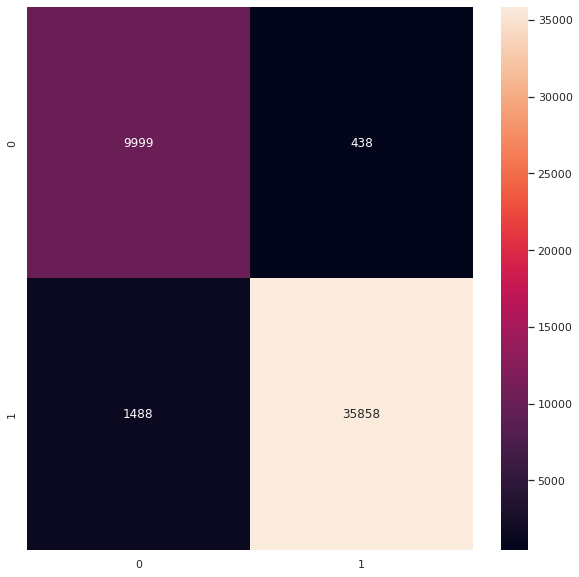

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="g")
plt.show()